# Тематическое моделирование.

## Часть 1.1 Определение кол-ва тем и классификация постов в разрезе тематических рубрик.

В настоящем ноутбуке описана и проведена работа по тематическому моделированию постов из официального телеграм канала Кинопоиск, предоставленного в рамках Хакатона, необходимая для дальнейшей классификации постов и проведения общего EDA.

**Данные**: текст постов, статистика постов и иные метаданные. Данные предоставлены заказчиком.

В рамках данной подзадачи проведены:

1) предобработка и формирование текста для обучения модели:
- удаление или замена артефактов, "мусора" в тексте
- токенизация текста
- лемматизация текста

2) подготовка тестового набора, обучение модели и опеределение количества тем/топиков

3) тематическое моделирование по заданному кол-ву топиков

4) определение тема для каждого топика для дополнительной классификации постов

В рамках тематического моделированию применены 2 различные модели, а также кластеризация текста.

Дополнительно оценена сложность текста


<a id="start"></a>
## 0 Подготовительная часть
Загрузим все необходимые библиотеки, базы библиотек, необходимых для тематического моделирования - базы русского языка, модули для токенизации и тегирования библиотеки обработки естественного языка nltk

In [ ]:
! pip install emoji --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
! pip install textstat --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.9 MB/s eta 0:00:00


In [ ]:
! pip install textblob --quiet

In [ ]:
! pip install dostoevsky

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199775 sha256=cbe054088d37cd9d25df75e440bcdc2217d747e8edf1895726a6549cd1665826
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
! python3 -m dostoevsky download fasttext-social-network-model

In [ ]:
# 1) основные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud # для отрисовки облака слов

# 2) для парсинга и удалений
import requests
from urllib.parse import urlencode
import re

# 3) для тематического моделирования
# подготовка и препроцессинг текста
import nltk
from nltk.corpus import stopwords # стопслова
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer # лемматизатор nltk
from pymystem3 import Mystem # лемматизатор Яндекса

from nltk.tokenize import RegexpTokenizer # токенизатор
from sklearn.feature_extraction.text import TfidfVectorizer # для векторного представления
from sklearn.feature_extraction.text import CountVectorizer # для векторного представления

# модель
import gensim # для LDA
import gensim.corpora as corpora # для формирования корпуса текста
from gensim.models import CoherenceModel # для определения когерентности
from sklearn.decomposition import LatentDirichletAllocation # модель LDA sklearn

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# 4) для кластеризации
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# 5) для анализа тональности
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import dostoevsky
from dostoevsky.models import FastTextSocialNetworkModel

nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews') # бза

# 6) для оценки сложности
import textstat

# 4) дополнительные библиотеки
from tqdm import tqdm_notebook # декоратор для индикаторов
import string # для обработки строк
import emoji # для обработки emoji
import datetime # для обработки дата-времени
import time # для расчета времени обработки ноутбука
from collections import Counter # для контейнеризации


from google.colab import drive # для подключения к Drive.Google
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
# общий стиль форматирования чисел
pd.set_option('display.float_format', '{:.2f}'.format)
# сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', 300)
# сброс ограничений на количество элементов в списке
pd.set_option('display.max_seq_items', 100)


In [ ]:
from collections import Counter

Библиотеки загружены корректно

In [ ]:
#засечем время выполнения кода
start_time = time.time()

<a id="downloading"></a>
## 1 Загрузка данных

Оригинальные наборы данных хранятся на внешнем Яндекс.Диске. Применим для загрузки набора данных с постами канала способ не требующий получения токена для доступа к Яндекс.Диску

In [ ]:
# ячейка закомментирована, т.к. файл уже загружен на Google.Drive при создании ноутбука
# код загрузки внешнего файла ниже

'''
# обращение к Яндекс.Диску
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # путь к api
public_key = 'https://disk.yandex.ru/d/ird40C5h0MtHvQ'  # ссылка на директорию

# загрузочная ссылка
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url) #запрос к файлу
download_url = response.json()['href']

# загрузка и сохранение файла  в папке на Google.Drive
download_response = requests.get(download_url)
with open('/content/drive/MyDrive/Хакатон Кинопоиск/kinopoisk_channel_posts_2023-01-21.csv', 'wb') as f:   # путь к файлу
    f.write(download_response.content)
'''

"\n# обращение к Яндекс.Диску\nbase_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # путь к api\npublic_key = 'https://disk.yandex.ru/d/ird40C5h0MtHvQ'  # ссылка на директорию\n\n# загрузочная ссылка\nfinal_url = base_url + urlencode(dict(public_key=public_key))\nresponse = requests.get(final_url) #запрос к файлу\ndownload_url = response.json()['href']\n\n# загрузка и сохранение файла  в папке на Google.Drive\ndownload_response = requests.get(download_url)\nwith open('/content/drive/MyDrive/Хакатон Кинопоиск/kinopoisk_channel_posts_2023-01-21.csv', 'wb') as f:   # путь к файлу\n    f.write(download_response.content)\n"

In [ ]:
# загрузка в датасет
posts_file = pd.read_csv('/Мастерская_Кинопоиск/data_source/kinopoisk_channel_posts_2023-01-21.csv')

In [ ]:
# проверим загрузку
#display(posts.info())
#display(posts.sample(5))

<a id="test_data"></a>
## 2 Подготовка текстового набора
### 2.1 Предобработка текста

In [ ]:
# оставим часть от оригинального датасета
df = posts_file[['id', 'date', 'text']].copy(deep=True)

Визуальный анализ текстового содержимого постов показывает, что в тексте используется дополнительная разметка Markdown, дополнительные символы, а также одинаковые предложения-призывы к действию. Например "Подписывайтесь на "Кинопоиск"(ссылка)". Не нужные части текста необходимо удалить для дальнейшего тематического моделирования анализа текста, определения его сложности, тональности и пр.

Поэтому:
- удалим из текста лишние пробелы и символы, ссылки, служебные знаки, знаки препинания
- приведем к строчным
- удалим эмоджи

In [ ]:
df['text_processed'] = df['text'] # новый столбец для обработки
df['text_processed'] = df['text_processed'].astype(str).str.strip() # удаление лишних пробелов, если есть
df['text_processed'] = df['text_processed'].str.lower() # приведение к строчным

In [ ]:
# зададим словарь для замены
replace_dict = {
    r'  ': ' ',  # удаление двойных пробелов
    r'—': '',  # удаление дефиса
    r'__' : ' ',
    r'\n\n': ' ',  # замена \n\n на пробел
    r'\n': ' ',  # замена \n\n на пробел
    r'\[\*\*': ' ',  # удаление [** и **]
    r'\*\*\]': ' ',
    r'\[': ' ',  # удаление скобок [ и ]
    r'\]': ' ',
    r'\*\*' : ' ', # удаление ** выделения жирным в  markdown
    r'\(https?://[^\)]+\)': '',  # удаление ссылок в скобках для markdown
    r'https?://[^\)]+': '', # удаление прямых ссылок
    r'\(@\w+\)': '',  # удаление упоминаний пользователей
    r'\(\)' : '',
    'подписывайтесь' : '',
    '«кинопоиск»' : '',
    r'\«' : '',
    r'\»' : '',
    '–' : ''
}

In [ ]:
# применим замену по словарю
df['text_processed'] = df['text_processed'].replace(replace_dict, regex=True)

In [ ]:
# удалим все знаки препинания с помощью метода библиотеки string
df['text_processed'] = df['text_processed'].str.replace('[{}]'.format(string.punctuation), '')

In [ ]:
# заменим кавычки типа « » на ""
#texts['text_processed'] = texts['text_processed'].replace(r'\«' , '')
#texts['text_processed'] = texts['text_processed'].replace(r'\»' , '')

In [ ]:
# удалим все эмодзи с помощью функции replace_emoji библиотеки emoji
for i in df['text_processed'].index:
    df.loc[i, 'text_processed'] = emoji.replace_emoji(df.loc[i, 'text_processed'], replace='')

Для дальнейшей работы создан дополнительный столбец с очищенным текстом, необходимый для лемматизации

### 2.1.1 Стоп-слова

Проверим в целом, какая частотность у слов в тексте постов, на основании этих данных дополним список стоп-слов, используемых для лемматизации. В работе используется стандартный список стоп-слов русского языка из библиотеки nltk, содержащего 151 слово.

Для проверки сформируем один списко всех слов из всех постов и посчитаем частоту вхождения каждого слова.

In [ ]:
# случайная выборка для просмотра текста
# texts.sample(5)

In [ ]:
# сбор всех слов в один список
all_words = ' '.join(df['text_processed']).split()

In [ ]:
# подсчет частоты слов в списке слов
word_counts = {}
for word in all_words:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

In [ ]:
# преобразуем результат подсчета в датафрейм
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['word', 'freq'])

In [ ]:
# рассмотрим первые слова, частота которых более 500
#word_counts_df.sort_values(by='freq', ascending=False).query('freq > 500')['word'].to_list()

In [ ]:
# рассмотрим стоп-слова из бибилиотеки nltk
#nltk.download('stopwords')
#stopwords.words('russian')

Экспресс-анализ списков слов показывает, что в список стоп-слов не входят различные местоимения, слова союзы, междометия, числительные и пр., которые целесообразно добавить список стоп-слов (см.ниже)

### 2.2 Препроцессинг и лемматизация

На данном этапе необходимо преобразовать текстовые значения в набор-список лемматизированных слов (приведенных словоформ к лемме - их нормальной (словарной) форме)

In [ ]:
# определим лемматизатор из библиотеки pymystem (лучше подходит для русского языка)
lem = Mystem()
# зададим стоп-слова
nltk.download('stopwords')
stop = stopwords.words('russian')

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# добавим дополнительные слова
stop.extend([
'я', 'а', 'да', 'но', 'тебе', 'мне', 'ты', 'и', 'у', 'на', 'ща', 'ага', 'ура',
'так', 'там', 'какие', 'который', 'какая', 'туда', 'давай', 'короче', 'кажется', 'вообще',
'ну', 'не', 'чет', 'неа', 'свои', 'наше', 'наш', 'весь', 'хотя', 'такое', 'например', 'кароч', 'как-то',
'нам', 'хм', 'всем', 'нет', 'да', 'оно', 'своем', 'про', 'вы', 'мs', 'тд',
'вся', 'кто-то', 'что-то', 'вам', 'это', 'эта', 'эти', 'этот', 'прям', 'либо', 'как', 'мы',
'просто', 'блин', 'очень', 'самые', 'твоем', 'ваша', 'кстати', 'вроде', 'типа', 'пока', 'ок',
'мочь', 'их', 'это', 'ещё', 'ты', 'год', 'самый', 'наш', 'который', 'свой', 'день', 'время',
'почему', 'есть', 'очень', 'кинопоиск', 'хороший', 'стать',
'1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 'девять', 'десять'
])

Создадим функцию для препроцессинга текста, которая проверяет на наличие стоп-слов, производит токенизацию (разделяет на элементы) и лемматизацию текста

In [ ]:
def preprocess_text(x):
    '''
    Функция препроцессинга текста принимает на вход строку, разделяет строку на слова (элементы),
    проверяет является ли элемент стоп-словом или пустым, производит лемматизацию элементов,
    записывает элементы в список, удаляя лишнии пробелы

    Источник: https://pypi.org/project/pymystem3/
    '''
    words = []
    for word in (''.join(lem.lemmatize(x))).split(' '):
        if word not in stop and word != '':
            words.append(word.rstrip())
    return words

In [ ]:
# для более быстрой обработки преобразуем в массив
text_data = df['text_processed'].to_numpy()

# создаем пустой список
text_data_lemmatized = []
# применяем функцию для создания лемматизированного текста
for text in tqdm_notebook(text_data): # итерирование по каждому элементу с отображением прогресса
    text_data_lemmatized.append(preprocess_text(text))

  0%|          | 0/23326 [00:00<?, ?it/s]

In [ ]:
# добавим в текстовый датафрейм столбец с лемматизированным текстом
df['text_lemmatized'] = text_data_lemmatized
df.sample(2)

,id,date,text,text_processed,text_lemmatized
4848,27034,2022-07-29 15:41:01+00:00,"Мультивселенная переработок и недоплат.\n\nСтудию Marvel нещадно громят за то, как она работает с авторами комиксов и художниками по спецэффектам. [Разбираемся](http://www.kinopoisk.ru/media/news/4006477/?utm_source=telegram&utm_medium=social), что происходит.",мультивселенная переработок и недоплат студию marvel нещадно громят за то как она работает с авторами комиксов и художниками по спецэффектам разбираемся что происходит,"[мультивселенная, переработка, недоплата, студия, marvel, нещадно, громить, работать, автор, комикс, художник, спецэффект, разбираться, происходить]"
19869,3830,2018-12-04 12:40:51+00:00,"По словам Роберта Де Ниро, Netflix планирует кинопрокат фильма Мартина Скорсезе «Ирландец». Стриминг-сервис уже наступил на горло своим правилам «кино только для подписчиков», и начал показывать фильмы собственного производства в кинотеатрах. Так, например, в избранных залах можно увидеть «Рому»...",по словам роберта де ниро netflix планирует кинопрокат фильма мартина скорсезе ирландец стримингсервис уже наступил на горло своим правилам кино только для подписчиков и начал показывать фильмы собственного производства в кинотеатрах так например в избранных залах можно увидеть рому альфонсо куа...,"[слово, роберт, де, ниро, netflix, планировать, кинопрокат, фильм, мартин, скорсез, ирландец, стримингсервис, наступать, горло, правило, кино, подписчик, начинать, показывать, фильм, собственный, производство, кинотеатр, избранный, зал, увидеть, ром, альфонсо, куарон, 14, декабрь, картина, досту..."


Сохраним результаты обработки текста в отдельный файл.

В результате предобработки, препроцессинга и лемматизации текста получили датасет, содержащий оригинальный текст постов, а также текст наобходимый и достаточный для тематического моделирования

In [ ]:
df.to_csv('/Мастерская_Кинопоиск/models/texts.csv', index=False)

Предварительный обзор текстов постов, экспресс-анализ данных, экспертная оценка телеграма Кинопоиска показывают, что в целом все посты в канале можно условно разделить на 5-10 тем в зависимости от содержания постов и наличия в них той или иной информации или призыва к действию. Однако, существует вероятность того, что часть постов попадут в тематическую рубрику с малым количеством постов, которые могут восприниматься на фоне остальной массы постов как аномалия.

<a id="modeling"></a>
## 3 Моделирование

<a id="gensim"></a>
### 3.1 Модель тематического моделирования LDA библиотеки gensim

#### 3.1.1 Обучение модели

Для определения тематических рубрик постов будем использовать модель  Latent Dirichlet Allocation из библиотеки для тематического моделирования [gensim](https://radimrehurek.com/gensim/models/ldamulticore.html), входящая в стандартный пакет и не требующая доп. установки. В различных источниках описан ряд преимуществ данной библиотеки перед аналоичными (например, sklearn и её модели LDA) за счет распараллеливания процесса обучения между несколькоми ядрами.

Для оценки количества тематических рубрик (топиков), на которые можно классифицировать посты в телеграме будем использовать [gensim.CohernseModel](https://radimrehurek.com/gensim/models/coherencemodel.html), позволяющая оценить когерентность (согласованность, связанность) текста в зависимости от количества тематических рубрик ([основа модели](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluatio))

В качестве лемматизатора будем использовать Mystem из библиотеки pymystem от Яндекса для более корректной обработки слов русского языка, чем nltk

**Опредление "границ"**

Для обучения модели и определения оптимального количества тематических рубрик необходимо подготовить стратифицированную выборку. Посмотрим, сколько постов в целом опубликовано в год, а также длину постов

In [ ]:
# преобразуем столбец с датой-временем и добавим год поста
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [ ]:
# количество постов в год
df.groupby('year')['id'].count().reset_index()

,year,id
0,2016,16
1,2017,1338
2,2018,2289
3,2019,3221
4,2020,4675
5,2021,4520
6,2022,4572
7,2023,2561
8,2024,134


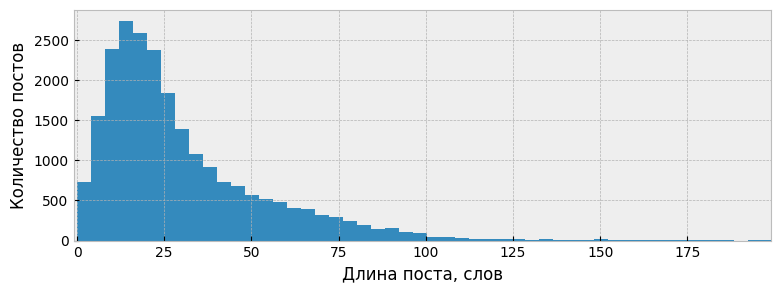

In [ ]:
# добавим столбец с длиной постов (число слов строке лемматизированных слов)
df['lenght'] = df['text_lemmatized'].apply(len)
# выведм на гистограмме
plt.figure(figsize=(9,3))
df['lenght'].hist(bins=100)
plt.xlabel('Длина поста, слов')
plt.ylabel('Количество постов')
plt.xlim(-1, 199)
plt.show()

In [ ]:
print(f'Количество постов в оригинальном наборе: {df.shape[0]}')
print('Количество постов c длиной менее 50 слов:', df[df['lenght'] <= 50].shape[0])
print('Доля постов длиной менее 50 слов: {:.2%}'.format(df[df['lenght'] <= 50].shape[0] / df.shape[0]))

Количество постов в оригинальном наборе: 23326
Количество постов c длиной менее 50 слов: 19272
Доля постов длиной менее 50 слов: 82.62%


Т.о. большая часть постов (80%) - текст длиной менее 50 слов.

#### 3.1.2 Тестовая модель и определение кол-ва топиков

Выше было показано, что в целом каждый год опубликовано 1300 до 4600 постов, кроме 2016 и 2024 года (конец и начало года). Поэтому, для обучения модели сформируем стратифицированную случайную выборку из постов за 2018-2023 гг. по 2000 постов за год

In [ ]:
# список постов-текстов для стратифицированной выборки
stratified_data = []
# отбор случайных 2000 постов-текстов
for i in [2018, 2019, 2020, 2021, 2022, 2023]:
    stratified_data.append(df.query('year ==@i').sample(2000))
# форимрование датафрейма отобранных постов
stratified_data = pd.concat(stratified_data)
print('6 лет, 2000 постов = ', stratified_data.shape[0], 'постов')

6 лет, 2000 постов =  12000 постов


In [ ]:
# преобразуем стратифицированный список в массив для ускорения вычислений
words = stratified_data['text_lemmatized'].to_numpy()

Для определения согласовнности текста данная модель использует биграммы (n-граммы) - 2 или более слов, которые находятся по соседству.

Например, в тексте "Рассказываем про вырезанный эпизод с так называемой зеркальной комнатой" биграммы это:
- вырезанный эпизод
- называемой зеркальной
- зеркальной комнатой

In [ ]:
# сформируем n-граммы (коллакации)
bigram = gensim.models.Phrases(words, min_count=3, threshold=10)
# oбнаружение фраз на основе количества словосочетаний
bigram_mod = gensim.models.phrases.Phraser(bigram)

Сформируем функцию, которая преобразует текст, обнаруживая и объединяя биграммы, возвращает список текстов с примененными биграммами

In [ ]:
def make_bigrams(texts):
    '''
    Функция принимает список текстов и возвращает список текстов, в которых каждое слово заменено его биграммой.
    '''
    bigram_texts = []
    for doc in tqdm_notebook(texts, leave=False):
        bigram_texts.append(bigram_mod[doc])
    return bigram_texts

In [ ]:
#  создадим список биграмм для каждого текста в списке words
words_bigrams = make_bigrams(words)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
# создадим словарь, в котором каждой уникальной биграмме сопоставляется уникальный идентификатор
id2word = corpora.Dictionary(words_bigrams)
print(f'Размер словаря на тестовой выборке: {len(id2word)}')

Размер словаря на тестовой выборке: 37542


Словарь целесообразно ограничить.

С другой стороны 37731 слов в словаре - крайне мало. Для подобных задач использутся словари большего размера, но и обучающая выборка нужна в 10 раз больше

In [ ]:

id2word.filter_extremes(no_below=3, no_above=0.5)
print(f'Размер словаря после фильтрации: {len(id2word)}')

Размер словаря после фильтрации: 15629


In [ ]:
# создаем тренировочный корпус текста, содержащий тексты с биграммами вместо отдельных слов
texts = words_bigrams

# преобразуем текст в вектор, где каждое уникальное слово представлено своим уникальным идентификатором, а его частота в тексте - количеством его вхождений
corpus = []
for text in texts:
    corpus.append(id2word.doc2bow(text))

Для определения количества топиков воспользуемся готовой [функцией](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) которая позволит определить значение коэффициента когерентности для различного количества топиков, на которые может быть разделен текст.

Максимальное значение коэффициента соответствует оптимальному значению кол-ва топиков, на которое целесообразно разделить посты.



In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, limit, step)):

        model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=42,
            chunksize=100,
            passes=10,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

**Описание функции**

Суть работы функции заключается в следующем:

1) Задается максимальное количество топиков, на которое предполагается (планируется) разделить текст

2) Модель LDA делит последовательно весь текст на разное количество топиков и рассчитывает коэффициенто связности текста в зависимости от количества топиков

3) МАксимальное значение коэффициента соответствует самому оптимальному количеству топиков, на которые следует разделить тексты

4) В зависимости от максимально заданного количества топиков результат может меняться.

Например, на вход функции подается число топиков 10, после обработки функции максимальное значение коэффициента соответсвует 5 топикам. Т.о. если разделить все тексты из набора на 10 топиков, то в 5 топиков попадёт большая часть  текстов с максимальной связностью, остальные тексты будут распределены между другими 5-ю топиками с минимальной связностью, которые могут считаться "мусором"

Аналогично, если задать максимальное число топиков 5, в результатом работы функции может стать меньшее число количества оптимальных топиков, например 2 (но и коэффициент связности будет выше, чем в первом случае). Основаня масса текста попадет в эти 2 топика, остальная меньшая часть будет распределна между 3-мя оставшимися топиками с минимальной связностью

Рассмотрим случай разделения текстов на 10 топиков. В настоящий момент мы не знаем возможное кол-во тем постов в канале, возможно их больше. С другой стороны, тем может быть не более 2-х.

Применим функцию compute_coherence_values для того, чтобы узнать значение коэффициентов когерентности текста в зависимости от количества топиков. Представим результаты работы функции в графическом виде

In [ ]:
# применим функцию, зададим максимальное кол-во топиков
max_topic_num = 5
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=texts,
    start=1, limit=max_topic_num, step=1
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# значения коэффициентов
coherence_values

[0.3998539696951472,
 0.4315872705477968,
 0.4398766782689674,
 0.4153194617616524]

Распределение значений коэффициентов в графическом виде

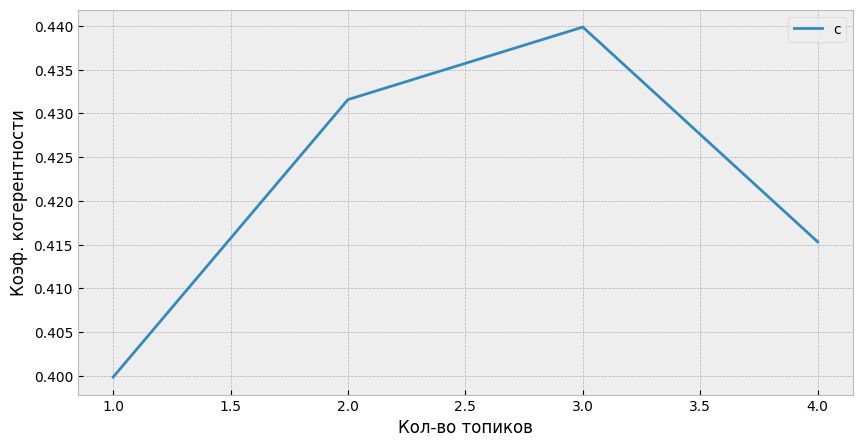

In [ ]:
# построим линейный график
x = range(1, 5)
plt.figure(figsize=(10,5))
plt.plot(x, coherence_values)
plt.xlabel("Кол-во топиков")
plt.ylabel("Коэф. когерентности")
plt.legend(("coherence_values"), loc='best')
plt.show()

Т.о. наиболее высокий коэффициент когерентности (согласованности) характерен для 1-3 топиков- почти 0,42, что вполне очевидно. Все посты в канале на одну тему. Но для детального тематического моделирования необходимо большее количество тем.

В целом в задачах тематического моделирования за хороший результат коэффициента связности принимаеются значения 0,40-0,45. Значения 0,45-0,5 и более - идеальный результат. Значения выше 0,6-0,65 не реальны для естественно-сгенерированного текста. Значение 1 - все тексты идентичны

#### 3.1.3 Моделирование на всем наборе

Применим аналогичный подход, используемый для тренировки модели, на всем наборе текста

In [ ]:
%%time
# перевод текста в массив
data_words = df['text_lemmatized'].to_numpy()
# формирование биграмм
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = make_bigrams(data_words)
# формирование словаря
id2word = corpora.Dictionary(data_words_bigrams)
print(f'Размер словаря до фильтрации: {len(id2word)}')
id2word.filter_extremes(no_below=3, no_above=0.8)
print(f'Размер словаря после фильтрации: {len(id2word)}')


texts = data_words_bigrams
# формирование корпуса текста
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(texts, leave=False)]

  0%|          | 0/23326 [00:00<?, ?it/s]

Размер словаря до фильтрации: 56539
Размер словаря после фильтрации: 25883


  0%|          | 0/23326 [00:00<?, ?it/s]

CPU times: user 6.82 s, sys: 160 ms, total: 6.97 s
Wall time: 7.18 s


Найдем оптимальное кол-во топиков для всего текста. Применим функцию compute_coherence_values для того, чтобы узнать значение коэффициентов когерентности текста в зависимости от количества топиков. Представим результаты работы функции в графическом виде

In [ ]:
# применим функцию, зададим максимальное кол=во топиков
max_topic_num = 7
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=texts,
    start=1, limit=max_topic_num, step=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# значения коэффициентов
coherence_values

[0.44082262911216075,
 0.40113570416665256,
 0.4608396261456263,
 0.4028233413061858,
 0.40036491562201776,
 0.3625462514740252]

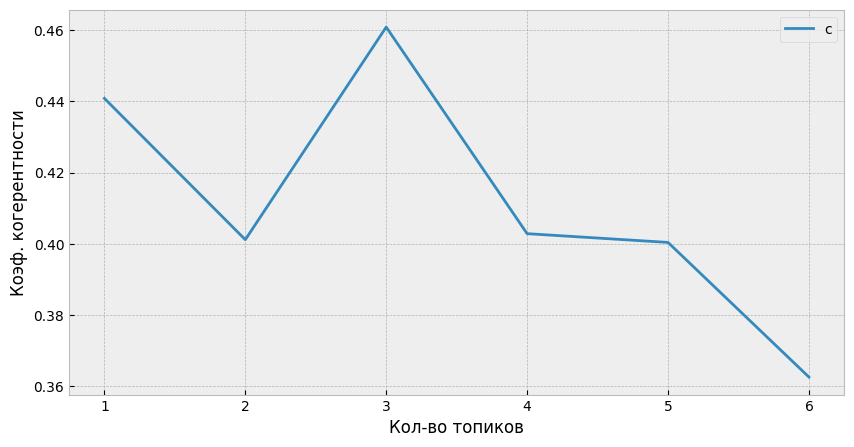

In [ ]:
x = range(1, 7)
plt.figure(figsize=(10,5))
plt.plot(x, coherence_values)
plt.xlabel("Кол-во топиков")
plt.ylabel("Коэф. когерентности")
plt.legend(("coherence_values"), loc='best')
plt.show()

Из распределения видно, что для полного корпуса текстов в соответствии с моделью также выделено 3 топика, который максимально точно или связно описывают набор с текстом.

В итоговой модели зададим число возможных топиков - 4, расчитаем итоговый коэффициент связности и сформируем итоговые датафреймы с результатами модели


In [ ]:
# сформируем итоговую модель
%%time
final_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=3, # кол-во топиков
            random_state=42,
            chunksize=100,
            passes=10,
        )

CPU times: user 1min 43s, sys: 4.55 s, total: 1min 48s
Wall time: 2min 11s


In [ ]:
# рассчитаем  значение коэффициента когерентности для всего текста
coherencemodel = CoherenceModel(model=final_model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.47780636420854933

In [ ]:
final_model.save('/content/drive/MyDrive/Хакатон Кинопоиск/models/final_model/final_model_4_topics')

Итоговый результат модели для 3 топиков - 0.4625, что является хорошим результатом тематического моделирования.

Коэффициент связности для всего набора теста - 0,4

В целом, для качественного моделирования необходимы более разнообразные тексты большего объема. В описании к модели и в различных примерах исследовательских работ, связанных с задачами тематического моделирования, используются корпусы текстов в 10 и более раз больше, чем наш набор.

Поэтому, оптимальное значение кол-ва топиков равного 4 в нашем случае вполне объяснимо, т.к. в целом тематика постов, размещаемых в канале, это информация о киноиндустрии, а количество постов не по теме - крайне низко (шум) и является нехарактерным (аномальным) для постов канала.

Сформируем итоговые результаты моделирования в виде дополнительных датафреймов

**ВАЖНО.** Стоит отметить, что результаты моделирования могут отличаться при перезапуске ноутбука, хотя в параметрах модели задано значение random_state. В описании модели указано, что "результаты все равно могут различаться из-за недетерминированности планирования рабочих процессов ОС."

In [ ]:
# формирование итоговых результатов "номер топика - слова"
topics_gensim = final_model.show_topics(num_topics=4, num_words=100, formatted=False)

In [ ]:
# сформируем датафрейм с коэффициентами связности для всех объектов (постов)
topic_vectors_gensim = []
for i in final_model.get_document_topics(corpus, minimum_probability=0):
    topic_vectors_gensim.append(dict(i))

topic_vectors_gensim = pd.DataFrame(topic_vectors_gensim)

In [ ]:
# преобразуем столбцы результатов, зададим новые номера топиков
topic_vectors_gensim = topic_vectors_gensim.astype(float)
topic_vectors_gensim = topic_vectors_gensim.rename(columns={0:1, 1:2, 2:3, 3:4})
topic_vectors_gensim

,1,2,3
0,0.29,0.69,0.02
1,0.01,0.78,0.21
2,0.04,0.60,0.36
3,0.01,0.87,0.12
4,0.33,0.64,0.03
...,...,...,...
23321,0.72,0.26,0.02
23322,0.86,0.07,0.07
23323,0.54,0.34,0.13
23324,0.20,0.65,0.15


Подготовим датасет, содержащий информацию о постах и № топика для каждого поста. Добавим в новые столбцы максимальное значение коэффициента связности и номер соответсвующего топика

In [ ]:
# новый датафрейм
df_gensim = pd.concat([df, topic_vectors_gensim], axis=1)

In [ ]:
# столбец с коэффициентом
df_gensim['cong_coef'] = df_gensim[[1, 2, 3]].max(axis=1)
# столбец с номером топика
df_gensim['topic_gensim'] = df_gensim[[1, 2, 3]].apply(lambda row: row.idxmax(), axis=1)

In [ ]:
#df_gensim.head(2)

In [ ]:
# удалим лишние столбцы
#df_gensim.drop([1,2,3], axis=1, inplace=True)

In [ ]:
df_gensim.groupby('topic_gensim')['id'].count().reset_index()

,topic_gensim,id
0,1,6010
1,2,10592
2,3,6724


#### 3.1.4 Визуализация результатов моделирования

Представим результаты моделирования в виде облака слов.

Для этого сформируем функцию отрисовки облака слов на основе полученных результатов.

Посмотрим также на самые популярные слова для кажлой темы в текстовом виде

In [ ]:
# функция для отрисовки облака слов
def generate_wordcloud(topic_words, topic_number):
    # собираем слова из топика
    words = [word[0] for word in topic_words]
    # создаем облако слов
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(words))
    # отображаем облако слов
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_number}')
    plt.axis('off')
    plt.show()

In [ ]:
# выведем самые популярные слова для каждой темы
words = []
for topic, word_list in topics_gensim:
    topic_words_list = [word[0] for word in word_list[:10]]
    words.append((topic, topic_words_list))
words

[(0,
  ['сериал',
   'новый',
   'трейлер',
   'посмотреть',
   'сезон',
   'смотреть',
   'выходить',
   'netflix',
   'первый_трейлер',
   'ролик']),
 (1,
  ['фильм',
   'кино',
   'режиссер',
   'рассказывать',
   'человек',
   'история',
   'снимать',
   'картина',
   'новый',
   'становиться']),
 (2,
  ['фильм',
   'новый',
   'проект',
   'режиссер',
   'роль',
   'сыграть',
   'картина',
   'актер',
   'первый',
   'появляться'])]

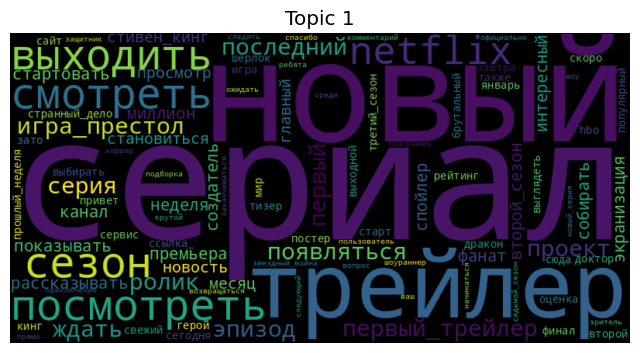

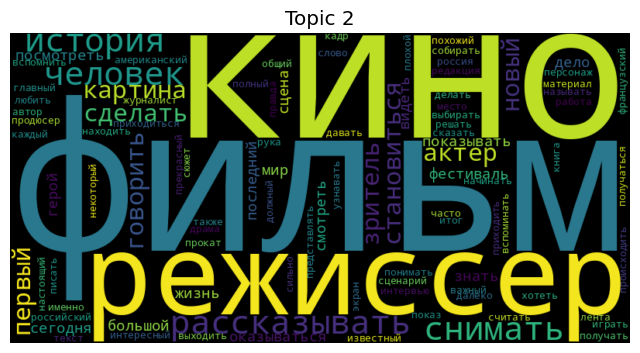

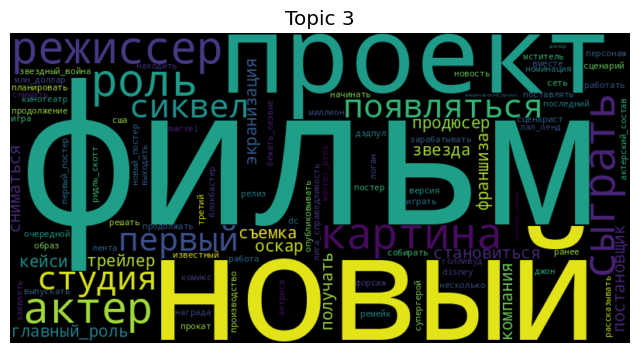

In [ ]:
# Проходим по каждому топику и строим облако слов
for i, topic in enumerate(topics_gensim):
    generate_wordcloud(topic[1], i+1)

На основе облака слов в целом можно выделить темы каждого из 3-х топиков, например
- топик 1 - "Популярные новые сериалы, новый сезон сериала, выход новох серии, которые ожидаются в ближайшее время"
- топик 2 - "Ретроспектива, рассказ о выпущенном фильме, история съемок, интересные факты. Интервью, подкаст, история про кино, актеров, режиссеров и киноиндустрию"
- топик 4 - "Информация о выходе нового фильма"

или проще:
- 1 Новый сериал
- 2 История
- 3 Новый фильм

<a id="sklearn"></a>
### 3.2 Модель тематического моделирования LDA библиотеки sklearn

В рамках моделирования при помощи библиотеки gensim был подготовлен ламматизированный текст и описаны его основные характеристики. Поэтому для применения других моделей нет необходимости проводить дополнительную предобработку и препроцессинг.

Воспользуемся набором текста, хранящегося в `text_lemmatized`

Для моделирования в библиотеке sklearn необходимо:
- сформировать корпус текста
- произвести векторизацию текста (т.е. превращение тектстовых значений в вектора)
- обучить модель
- определить номера топиков и их основные характеристики

#### 3.2.1 Подготовка данных и обучение модели

In [ ]:
# загрузим необходимые для модели базы слов
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# сформируем функцию для препроцессинга, необходимую для работы модели
def preprocess_text(text):
    text = ' '.join(text).lower()  # Приведение к нижнему регистру
    text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
    tokens = nltk.word_tokenize(text)  # Токенизация
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop]  # Лемматизация и удаление стоп-слов
    return ' '.join(tokens)

In [ ]:
%%time
lemmatizer = WordNetLemmatizer() # лемматизатор
# представление текстов
corpus_lda = df['text_lemmatized'].to_list() # Пример текстов постов
preprocessed_corpus = [preprocess_text(text) for text in corpus_lda]

CPU times: user 15.4 s, sys: 114 ms, total: 15.5 s
Wall time: 15.6 s


In [ ]:
%%time
# подключение векторизации
vectorizer = CountVectorizer(max_features=10000)
# подготовка данных для моделирования
X = vectorizer.fit_transform(preprocessed_corpus)

CPU times: user 921 ms, sys: 17.1 ms, total: 938 ms
Wall time: 947 ms


#### 3.2.2 Применение модели, формирование результатов

In [ ]:
%%time
# зададим количество тем
num_topics = 3
# определим модель
lda_model = LatentDirichletAllocation(n_components=num_topics,  random_state=42)
# обучаем модель
lda_model.fit(X)

CPU times: user 1min 23s, sys: 558 ms, total: 1min 24s
Wall time: 1min 24s


LatentDirichletAllocation(n_components=3, random_state=42)

In [ ]:
%%time
# применим модель
#преобразуем текст в векторное представление
text_vectorized = vectorizer.transform(preprocessed_corpus)
# применим модель
topic_distribution = lda_model.transform(text_vectorized)

# Добавляем столбец с результатами в датафрейм
#texts['topic'] = topic_distribution.argmax(axis=1)

CPU times: user 6.24 s, sys: 38.3 ms, total: 6.28 s
Wall time: 6.34 s


In [ ]:
# создадим доп датафрейм для записи результатов моделирования 2-м сопособом
df_sklearn = df.copy(deep=True)

In [ ]:
#добавим новый столбец в датафрейм, отражающий номер самого вероятного топика
# т.е. номер топика, для которого коэффициент "похожести" максимальный
df_sklearn['topic_sklearn'] = topic_distribution.argmax(axis=1)

#### 3.2.3 Интерпретация результатов

Получим список наиболее вероятных слов для каждого топика и представим распределение слов в каждом топике в виде облака слов.


In [ ]:
# распределение постов по топикам
df_sklearn.groupby('topic_sklearn')['id'].count().reset_index().sort_values(by='id', ascending=False)

,topic_sklearn,id
2,2,8489
1,1,7478
0,0,7359


In [ ]:
# интерпретация тем в текстовом виде
feature_names = vectorizer.get_feature_names_out()
for num, topic in enumerate(lda_model.components_):
    print(f'topic {num}:')
    print([feature_names[i] for i in topic.argsort()[-20:]])  # наиболее вероятные слова для каждой темы

topic 0:
['сценарий', 'выходить', 'сюжет', 'первый', 'получать', 'прокат', 'сыграть', 'оскар', 'новый', 'getty', 'проект', 'image', 'становиться', 'актер', 'фото', 'главный', 'картина', 'роль', 'режиссер', 'фильм']
topic 1:
['снимать', 'сегодня', 'актер', 'выходить', 'герой', 'жизнь', 'человек', 'выпуск', 'российский', 'посмотреть', 'история', 'смотреть', 'главный', 'режиссер', 'новый', 'рассказывать', 'подкаста', 'сериал', 'кино', 'фильм']
topic 2:
['роль', 'герой', 'становиться', 'появляться', 'серия', 'шоу', 'netflix', 'второй', 'игра', 'премьера', 'главный', 'рассказывать', 'проект', 'трейлер', 'фильм', 'выходить', 'первый', 'сезон', 'новый', 'сериал']


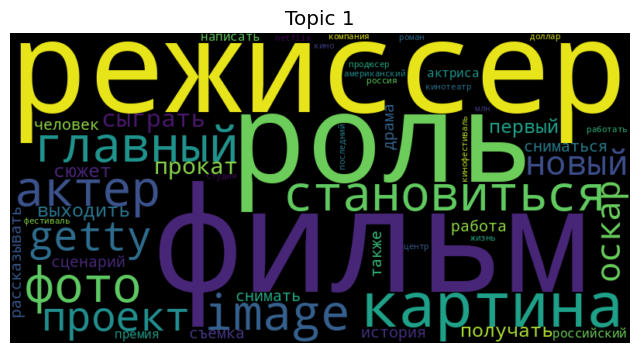

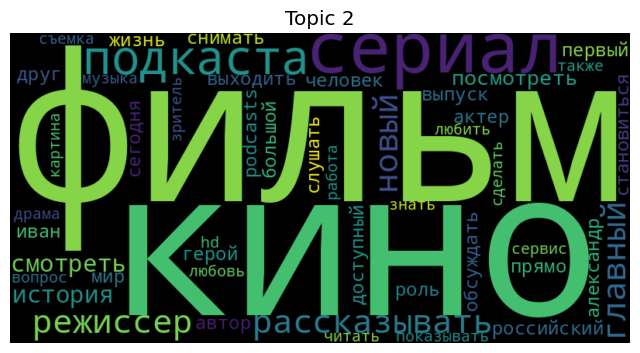

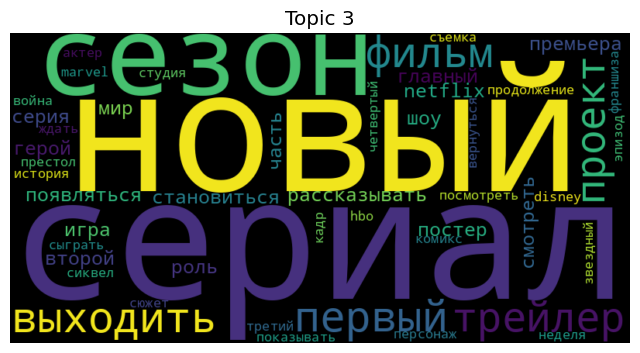

In [ ]:
# интерпретация тем в графическом виде
num_words = 50  # Количество слов для каждой темы
topic_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[-num_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words.append(top_words)

# cоздание облака слов для каждой темы
for i, words in enumerate(topic_words):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(words))
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i+1}')
    plt.axis('off')
    plt.show()

На основе вхождения наиболее вероятных слов в каждый топик можно определить примерное содержание каждого топика
- топик 1 - "Обсуждение выхода нового фильма"
- топик 2 - "История о кино"
- топик 4 - "Обсуждение выхода нового сезона сериала"

или проще:
- 1 Кинопремьера
- 2 История
- 3 Новый сериал

В целом аналогичное распеределение по темам было получено предыдущим методом

<a id="cluster"></a>
### 3.3 Кластеризация текста

Кластеризация текста также подразумевает под собой представление текста в виде векторов. Для решения задачи кластеризации предлагается использовать векторизацию методом TfidfVectorizer из библиотеки nltk.

Аналогично предыдущим методам, попробуем выделить 3 кластера текста



In [ ]:
df_cluster = df.copy(deep=True)

In [ ]:
%%time
# предобработка текста
# преобразуем лемматизированный текст в список
preprocessed_corpus = [' '.join(text) for text in df['text_lemmatized']]
# зададим векторизацию
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
X = vectorizer.fit_transform(preprocessed_corpus)

# выбор и обучение модели кластеризации
num_clusters = 3  # Задаем количество кластеров
kmeans = KMeans(n_clusters=num_clusters, random_state=42) #
pipeline = make_pipeline(Normalizer(), kmeans)
pipeline.fit(X)

# присваивание кластеров каждому тексту
df_cluster['cluster'] = pipeline.predict(X)

CPU times: user 6.44 s, sys: 138 ms, total: 6.58 s
Wall time: 4.03 s


In [ ]:
df_cluster.groupby('cluster')['id'].count().reset_index()

,cluster,id
0,0,351
1,1,18313
2,2,4662


In [ ]:
print('Доля постов во 2-им кластере {:.2%}'.format(df_cluster.query('cluster == 1').shape[0] / df_cluster.shape[0]))

Доля постов во 2-им кластере 78.51%


В настоящий момент мы не знаем, какая тема соответствует какому кластеру
Основная часть постов попала в кластер 2 (78%  постов)

Проверим, что это за посты (во всех кластерах)

In [ ]:
for i in df_cluster['cluster'].unique():
    display(f'Кластер {i}')
    display(df_cluster.query('cluster == @i')[['id', 'text']].sample(5))

'Кластер 1'

,id,text
20245,3406,"Николь Кидман на днях дала интервью изданию The Cut, в котором рассказала, что брак с Томом Крузом имел одно огромное преимущество: он спас ее от сексуальных домогательств в Голливуде. Там еще про то, что ее первым серьезным решением была покупка квартиры в 19 (!) лет, и пусть это была крохотная..."
17677,7089,"10 лучших мультфильмов Disney: Выбор редакции и читателей\n\nМы с вами очень разные, поэтому у нас всего один пункт совпал. Зато у нас теперь есть лучшие диснеевские мультики по двум версиям: http://amp.gs/rGir"
21428,2124,"В четверг в прокат вышел «Тренер» — режиссёрский дебют Данилы Козловского, который также исполняет в фильме главную роль. Мы собрали для вас ещё пять фильмов с Козловским, которые можно бесплатно посмотреть на КиноПоиске https://vk.com/@kinopoisk-pyat-filmov-s-daniloi-kozlovskim"
18083,6405,Депутат Госдумы попросил проверить деятельность студии Kinodanz: http://amp.gs/dAOq
10347,17890,"Съемки сиквела «Мег» стартуют в январе следующего года! Об этом [рассказал](https://collider.com/the-meg-2-jason-statham-filming-start-date/) Джейсон Стэйтем.\n\nРежиссер второй части — Бен Уитли («Высотка», «Перестрелка»).\n\nВ боевике 2018 года Стэйтем сыграл дайвера, который пытается спасти г..."


'Кластер 2'

,id,text
9003,19896,"Вышел [трейлер](https://www.youtube.com/watch?v=B91pn159FNk) российского сериала «Коса», который [победил](https://t.me/kinopoisk/19456) на Нью-Йоркском кинофестивале (INYFF) как лучшее ТВ/веб-шоу.\n \nВ центре сюжета — следовательница Ева Кайдас (Линда Лапиньш). Ей поручают дела об убийствах де..."
1022,34625,Дэниэл Рэдклифф набрал к лету и не сдулся под конец. Наш герой! 💪\n\nРеспектуем актеру и бежим смотреть все сезоны [**«Чудотворцев»**](https://www.kinopoisk.ru/series/1111018?utm_source=telegram&utm_medium=social) (18+) в Плюсе.
3882,28940,"В Великобритании [начались](https://www.hollywoodreporter.com/tv/tv-news/the-rings-of-power-season-2-filming-1235231978/) съемки второго сезона сериала «Властелин колец: Кольца власти».\n\nПервый сезон снимался в Новой Зеландии, съемки второго были перенесены в Великобританию для экономии и удоб..."
14154,12280,"«Друзья» — [самый популярный сериал стрим-сервиса HBO Max](https://www.kinopoisk.ru/media/news/4002276/?utm_source=telegram&utm_medium=social). На втором месте оказался комедийный сериал-антология «Личная жизнь» с Анной Кендрик, который, как утверждается, лишь немногим уступает «Друзьям». Замыка..."
9949,18450,Почему сериал [«Друзья»](https://www.kinopoisk.ru/film/77044/) можно назвать культурным кодом людей всего мира? В какой момент жизни именно друзья становятся семьей и спасают от одиночества? Что интересного мы узнали из специального эпизода [«Друзья: Воссоединение»](https://www.kinopoisk.ru/film...


'Кластер 0'

,id,text
16601,8677,Можно послушать #подкаст прямо тут
10236,18057,Также #подкаст можно слушать прямо в Telegram.
2877,30773,А еще наш #подкаст можно слушать прямо здесь.
5896,24732,"Напоминаем, что наш #подкаст также есть в Telegram."
7432,22422,И просто так напоминаем: слушайте этот #подкаст прямо в Telegram.


Напрямую визуально тематического разделения постов выявить нельзя
Скорее всего:
- в 0-м кластере - информация о подкастах (можно отнести в раздел "Другое")
- во 1-м кластере - посты на околокинематографическую тематику (раздел - "История")
- в 2-м кластере - информация о новых сериалах и новых фильмах (можно отнести в раздел "Новый сериал" или "Новый фильм")

### 3.4 Вывод по итогам моделирования

Для тематического моделирования были применены 3 разных метода (алгоритма):
- 2 метода основаные на латентном распределении Дирихле, с использованием различных токенизаторов, веторизаторов и лемматизаторов
- кластеризация текста.

В результате моделирования с помощью бибилиотеки gensim было определнео оптимальное кол-во топиков (тем) для дальнейшей классификации постов и коэффициент когерентности или связнсоти текста. выявлено основных 3 темы постов канала.

Дополнительно с помощью методов библиотеки sklearn и методов кластеризации были определены аналогичные 4 тематические рубрики постов для возможной декомпозиции.

Однако, т.к. непосредственно тема топика задается вручную, могут возникнуть ошибки при определении темы того или иного топика:
- Топик - номер тематической рубрики, определенный моделью.
- Тема - заданная вручную тематическая рубрика на основе анализа ключевых слов, входящих в топик, коэффициента связности, экспертного мнения и иных факторов.

<a id="collect"></a>
## 4 Объединение результатов моделирования

Сформируем датафрейм, содержащий значения топиков, определенных 3-мя способами

In [ ]:
# создадим новый датафрейм копию
df_result = df.copy(deep=True)

In [ ]:
# добавим результаты моделирования
df_result['cong_coef'] = df_gensim['cong_coef']
df_result['topic_gensim'] = df_gensim['topic_gensim']
df_result['topic_sklearn'] = df_sklearn['topic_sklearn']
df_result['cluster'] = df_cluster['cluster']

In [ ]:
df_result.groupby('topic_gensim')['id'].count()

topic_gensim
1     6010
2    10592
3     6724
Name: id, dtype: int64

In [ ]:
# изменим порядок нумерации тем
topic_dict = {0:1, 1:2, 2:3}
df_result['topic_sklearn'] = df_result['topic_sklearn'].replace(topic_dict)
df_result['cluster'] = df_result['cluster'].replace(topic_dict)

In [ ]:
df_result.groupby('cluster')['id'].count()

cluster
1      351
2    18313
3     4662
Name: id, dtype: int64

Преобразуем численные значения топиков и кластеров в текст. Для этого напишем ряд функции, которые будут возвращать заданную текстовую классификацию в соответствии со значением.

Примерный перечень тем, тематических рубрик был определен в предыдущем разделе. Возможно первончальное определение топика как "Ретроспектива" не совсем корректно. Под ректроспективой имеется ввиду в т.ч. и описание некого события, сопутствующее выходу фильма или сериала, а также короткая заметка на "околокиношную" тему

In [ ]:
def gensim_topic(row):
    if row == 1:
        return 'Новый сериал'
    if row == 2:
        return 'История'
    if row == 3:
        return 'Кинопремьера'

def sklearn_topic(row):
    if row == 1:
        return 'Кинопремьера'
    if row == 2:
        return 'История'
    if row == 3:
        return 'Новый сериал'

def cluster_topic(row):
    if row == 1:
        return 'Другое'
    if row == 2:
        return 'История'
    if row == 3:
        return 'Кинопремьера'

In [ ]:
%%time
# применим функции
df_result['topic_1'] = df_result['topic_gensim'].apply(gensim_topic)
df_result['topic_2'] = df_result['topic_sklearn'].apply(sklearn_topic)
df_result['topic_3'] = df_result['cluster'].apply(cluster_topic)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 26 ms


### 4.1 Подход к выделению основной темы

In [ ]:
# посмотрим на общее распеределение тем
global_topic_distribution = df_result.groupby(['topic_1', 'topic_2', 'topic_3'])['id'].count().reset_index().sort_values(by='id', ascending=False)
global_topic_distribution
#display(global_topic_distribution)


,topic_1,topic_2,topic_3,id
1,История,История,История,4845
9,Кинопремьера,Кинопремьера,История,3416
3,История,Кинопремьера,История,3280
11,Кинопремьера,Новый сериал,История,2544
19,Новый сериал,Новый сериал,Кинопремьера,2327
18,Новый сериал,Новый сериал,История,1465
5,История,Новый сериал,История,1363
14,Новый сериал,История,История,860
15,Новый сериал,История,Кинопремьера,608
2,История,История,Кинопремьера,593


Т.о. весь набор в настоящий момент можно условно разделить на 20 тем)
Теперь необходимо определить "главную тему" исходя из значений смоделированных тем.

В целом результаты кластеризации могут помешать полноценному расперделению, т.к. в кластере №2 "История" (оригинальный номер 1) содержится 17 тыс постов (почти 78% всех постов)

Проверим некоторые рубрики


In [ ]:
top_10 = global_topic_distribution.head(10)
top_10_1 = top_10['topic_1'].to_list()
top_10_2 = top_10['topic_2'].to_list()
top_10_3 = top_10['topic_3'].to_list()

for i, j, k, l in zip(top_10_1, top_10_2, top_10_3, range(1,11)):
    print(f'{l})Тройка {i}-{j}-{k}')
    display(df_result.query('topic_1 == @i and topic_2 == @j and topic_3 == @k')[['id', 'text']].sample(5))

1)Тройка История-История-История


,id,text
17230,7766,⚡⚡⚡Александр Петров приближается к Оскару!\n\nhttp://amp.gs/NaqS
2319,31784,"Прогрессивная студентка оказывается во власти богатого красавца — такова завязка мелодрамы «Непослушная» с Александром Петровым, которую уже окрестили ответом «Пятидесяти оттенкам серого».\n\nОба фильма и правда похожи, но не так сильно, как может показаться по синопсису. \n\nПодробнее о новинк..."
15847,9793,«Безмятежность сейчас». Звучит\n\nhttp://www.kinopoi.sk/JEr7
15586,10151,"26 марта на КиноПоиск HD эксклюзивная премьера — народная сай-фай комедия «Проект «Анна Николаевна». Это история про девушку-андроида, которую отправляют проходить испытания в отделение МВД маленького городка. Там робот-полицейский с внешностью топ-модели и интеллектом Всемирной энциклопедии буд..."
15145,10729,Любой желающий может стать частью комедии «Билл и Тед»: достаточно [записать веселое музыкальное видео и отправить его авторам фильма](https://www.kinopoisk.ru/media/news/4001474/). Строгих правил нет. Главное — проявить фантазию и дать волю воображению.


2)Тройка Кинопремьера-Кинопремьера-История


,id,text
7862,21690,"Джона Хилл [снимется](https://deadline.com/2021/11/jonah-hill-jerry-garcia-martin-scorsese-grateful-dead-pic-apple-1234875832/) в фильме Мартина Скорсезе о рок-группе Grateful Dead. Хилл сыграет ее лидера Джерри Гарсию.\n\nСценаристы — Скотт Александер и Ларри Карацевски, написавшие шоу «Америка..."
8266,21042,"Кинокомпании всерьез взялись за одного из главных американских писателей современности — Дона Делилло.\n\nЕго последний роман «Молчание» (вышел в 2020 году) [экранизирует](https://variety.com/2021/film/news/jez-butterworth-don-delillo-the-silence-indiana-jones-5-1235087278/) Джез Баттеруорт, дра..."
12485,14588,"Зази Битц («Атланта», «Дэдпул 2») [сыграет](https://variety.com/2020/film/news/zazie-beetz-brad-pitt-bullet-train-1234831603/) в боевике [«Скоростной поезд»](https://www.kinopoisk.ru/film/1392550/). Актриса присоединилась к Брэду Питту, Джои Кинг, Аарону Тейлору-Джонсону и Эндрю Кодзи.\n\nКартин..."
9246,19562,"Боевик Джона Карпентера [«Побег из Нью-Йорка»](https://www.kinopoisk.ru/film/4404/) выйдет в российский прокат.\n\nКомпания «Иноекино» покажет 4К-версию. Ее создали в 2018 году, отреставрированный вариант одобрили режиссер и оператор картины, которая в этом году отмечает 40-летие. \n\nЭто предос..."
19620,4106,"Критики ассоциации Broadcast Film Critics объявили лауреатов премии Critics’ Choice Awards. Главный приз взяла черно-белая драма Альфонсо Куарона «Рома». В общей сложности лента одержала победу в четырех категориях, включая «Лучший режиссер».\n\nhttps://clck.ru/F3LeA"


3)Тройка История-Кинопремьера-История


,id,text
17587,7205,"Джим Керри — идеальный актер. Многие умеют играть драму, но совсем не умеют комедию. Он умеет всё. \n\nНи одной номинации на Оскар. Два «Золотых Глобуса» — за «Человека на Луне» и «Шоу Трумана»"
9602,19028,Посмотрите первый [трейлер](https://www.youtube.com/watch?v=83552gdXbP4&t=1s) фильма «История моей жены» — участника конкурсной программы Каннского кинофестиваля.\n\nКартина Ильдико Эньеди — экранизация одноименного романа венгерского писателя Милана Фюшта. По сюжету капитан Якоб Штэрр заключает...
2382,31663,"«Ла-Ла Ленд» [станет](https://variety.com/2023/legit/news/la-la-land-musical-broadway-1235515365/) бродвейским мюзиклом!\n\nПостановкой по фильму Дэмьена Шазелла займется режиссер Баттлер Шер («Убить пересмешника»). Каст и дата премьеры еще не объявлены.\n\nНе удивлены такому выбору, ведь музыка..."
14789,11268,"Хью Джекман опубликовал в Twitter фотографию, на которой чернокожий протестующий обнимает полицейского. «Единство», — подписал актер в попытке показать, что две стороны конфликта способны к взаимопониманию. Однако в сети его пост расценили иначе: [актера обвинили в пропаганде полиции](https://ww..."
21794,1729,"В минувшие выходные в Роттердаме завершился ежегодный кинофестиваль, который имеет репутацию одного из самых дерзких и экспериментальных киносмотров Европы и в первую очередь известен как соревнование молодых режиссеров. Именно на местных кинособытиях подрастает новое поколение постановщиков из ..."


4)Тройка Кинопремьера-Новый сериал-История


,id,text
18470,5692,**Какой из фильмов Марвел посоветовали бы пересмотреть прямо сейчас?**\n__anonymous poll__\n\nСтражи Галактики – 955\n👍👍👍👍👍👍👍 34%\n\nЖелезный человек – 864\n👍👍👍👍👍👍 31%\n\nДоктор Стрэндж – 329\n👍👍 12%\n\nМстители – 172\n👍 6%\n\nПервый мститель – 109\n👍 4%\n\nТор – 108\n👍 4%\n\nЧеловек-паук – 105\...
4453,27857,Студия Marvel [ведет переговоры](https://www.hollywoodreporter.com/movies/movie-news/fantastic-four-marvel-director-2024-movie-1235162665/) с Мэттом Шекманом. Он может стать режиссером «Фантастической четверки».\n\nШекман уже работал с Marvel над сериалом «Ванда/Вижн». Среди его предстоящих прое...
18320,5960,Паттинсон может стать новым Бэтменом. Как вам такой подбородок?\n\nНовость тут: http://amp.gs/UWO7
1499,33464,"Сегодня «Человеку из стали» исполнилось 10 лет, а недавно на Кинопоиске завершился третий сезон [**«Супермена и Лоис»**](https://www.kinopoisk.ru/series/1316617/).\n\nЧем не повод выбрать лучшего экранного Супермена? Пишите в комментариях, кто ваш любимчик!\n\nНа фото: 1. Генри Кавилл. 2. Кристо..."
23058,334,Парад новых постеров продолжает «Лига справедливости» Зака Снайдера. Свежий трейлер — уже в субботу.


5)Тройка Новый сериал-Новый сериал-Кинопремьера


,id,text
1419,33633,"Второй сезон **«Пищеблока»** стартует 8 июля, а пока рассказываем и показываем, как снималось продолжение. \n\nПо [ссылке](https://www.kinopoisk.ru/media/article/4008028/?utm_source=telegram&utm_medium=social) фоторепортаж со съемочной площадки, подробности сюжета и комментарии создателей.\n\n__..."
13115,13763,"Сериал «Блеск» о женском рестлинге [не вернется на экраны](https://www.kinopoisk.ru/media/news/4002994/?utm_source=telegram&utm_medium=social). Netflix прекратил производство четвертого сезона, который был заказан в августе 2019-го."
21399,2155,Сериал «Очень странные дела» назван самым популярными проектом Netflix.\n\nhttps://clck.ru/DFgQE
9680,18910,"Третий сезон «Сексуального просвещения» еще ближе! Он [выйдет](https://twitter.com/netflix/status/1408054803654082566) 17 сентября.\n\nВыше — первые кадры, а [здесь](https://www.kinopoisk.ru/media/article/4000363/) — самые яркие моменты второго сезона, которые скрасят ваши ожидания."
3540,29509,А вот и постер сериала.


6)Тройка Новый сериал-Новый сериал-История


,id,text
21066,2508,Можете отличить «Суперсемейку» от «Корпорации монстров»? А если что-нибудь посложнее? Сделали для вас новый тест на знание мультфильмов студии Pixar. Проходите!\n\nhttps://clck.ru/Ddwx5
1010,34637,"Любите «Интерстеллар», «Звездные войны» и другую стильную космическую фантастику?\n\nНе пропустите наш [новый стрим](https://t.me/igrapoisk/1704), посвященный одной из главных игр этого года."
15894,9735,Дерзайте! Все подробности ниже\n\nhttp://www.kinopoi.sk/JB0v
23077,312,Первый официальный постер «Темной башни» по Стивену Кингу.
2370,31687,"Флэш ускоряется на пути к финалу, Янковский и Бортич расследуют убийства, а в Готэме разлетаются валентинки.\n\nЧто смотреть дома? Читайте в [нашем дайджесте](https://www.kinopoisk.ru/news/4007432/) главных онлайн-новинок недели."


7)Тройка История-Новый сериал-История


,id,text
16319,9113,"Премьера постера на КиноПоиске! \n\n«Правда» — под таким названием французская кинозвезда Фабьенн выпускает свои мемуары. С названием готова поспорить ее дочь-сценаристка, которая, приехав из Америки с мужем — актером сериалов и дочкой, не нашла в книге ни слова правды — по крайней мере, о себе...."
22020,1478,"Мрачная, но жизнерадостная «Семейка Аддамс» давно стала одним из главных произведений поп-культуры 20-го века. То, что изначально было придумано как сатира на классическое американское общество, помешанное на образе «идеальной» семьи, впоследствии переросло в икону для движения готов и просто ку..."
6174,24256,"Уокер Скобелл («Проект „Адам“») [сыграет](https://variety.com/2022/tv/news/percy-jackson-disney-plus-series-cast-walker-scobell-1235228353/) в сериале о Перси Джексоне. \n\nПо сюжету 12-летний полубог Перси (Скобелл) только начинает привыкать к своим сверхъестественным способностям, когда Зевс о..."
16816,8379,У нас вышел большой репортаж со съемок фантастического триллера «Аванпост».\n\nВнутри — много фото и интересных подробностей.\n\nhttp://amp.gs/sC9E
1736,32931,"«Пятый элемент» без Миллы Йовович? И Брюса Уиллиса?! \n\nФантастика Люка Бессона могла получиться совсем другой или не выйти вовсе, но режиссер смог преодолеть все трудности и снять кино своей мечты. \n\nОб всем этом — в [нашем новом видео.](https://youtu.be/7MIf_4sr8rg)"


8)Тройка Новый сериал-История-История


,id,text
8565,20615,В Сочи вчера стартовал 32-й «Кинотавр». Мы смотрели красную дорожку (и даже вели трансляцию в Instagram) и выбрали самые классные наряды.\n\n#Кинотавр2021
2781,30952,"Отправляемся в прошлое майора Грома, за 20 лет до событий «Чумного Доктора».\n\nВ [финальном трейлере](https://www.youtube.com/watch?v=6hmikxctUlM) «Гром: Трудное детство» Константин Гром охотится за Анубисом, а сын полицейского Игорь ввязывается в сомнительные авантюры.\n\nДо премьеры осталось ..."
670,35464,"**Лук — многослоен. Кинопоиск — тоже!**\n\nСпециально для вас собрали ВСЕ наши Telegram-каналы в одну папку, чтобы было удобно: **https://t.me/addlist/m_O1AAzJJn80YjUy** \n\nВнутри: каналы про Плюс, оперативные новости из мира кино и сериалов, каналы про индустрию, игры, спорт, подкасты, видеоэс..."
1493,33477,Стрим Red Dead Redemption 2 вместе с **Костей Плотниковым** из «Короля и Шута» — начинаем уже через полчаса!\n\n**Ссылка на прямой эфир:\n**https://www.youtube.com/watch?v=8C_zHylIP54\n\n**Где еще можно следить за трансляцией:\n\n**Twitch — https://www.twitch.tv/igrapoisk\n«Вконтакте» — https://...
6246,24158,Еще наш #подкаст есть в Telegram.


9)Тройка Новый сериал-История-Кинопремьера


,id,text
11971,15353,Вышел [тизер](https://www.youtube.com/watch?v=dZdJs3C3uXg&feature=emb_title&ab_channel=START) сериала «Вампиры средней полосы» с Юрием Стояновым и Артемом Ткаченко. Подробности — [здесь](https://www.kinopoisk.ru/media/news/4003706/?utm_source=tg&utm_medium=social).
10134,18192,Пионерская смена началась! Премьера [«Пищеблока»](https://hd.kinopoisk.ru/film/4385d995088540caad8e530cc25f8a2d/?utm_medium=smm&utm_source=tg&utm_campaign=[kitchenblock]&utm_content=kinopoisk_group&utm_term=premiere&source=kinopoisk_smm_tg_[kitchenblock]_kinopoisk_group_premiere) уже на КиноПоис...
2803,30919,Финальный штрих нашего спецпроекта — топ-10 великих сериалов XXI века по мнению всей редакции Кинопоиска.\n\nОсновной топ-100 смотрите [по ссылке](https://www.kinopoisk.ru/media/article/4007086/). \n\n#КП100ВеликихСериалов
10035,18305,Кто главный герой в [«Вампирах средней полосы»](https://www.kinopoisk.ru/film/1224067/) — дед Слава ([Юрий Стоянов](https://www.kinopoisk.ru/name/245733)) или следователь из Москвы ([Михаил Гаврилов-Третьяков](https://www.kinopoisk.ru/name/2453626))? Какую роль в сюжете играет Смоленск? И почему...
7472,22352,"Слушайте этот #подкаст прямо в Telegram. \n\n__P.S. В новогодние каникулы мы собираемся выпустить эпизод о любимых сериалах, которые Лиза и Ваня планируют пересмотреть, и хотим включить в него отзывы и истории наших слушателей. Какие сериалы вы можете назвать самыми надежными и проверенными врем..."


10)Тройка История-История-Кинопремьера


,id,text
15742,9957,"Оригинальный сериал Спилберга выходил в 1985—1986. В антологии чередовались все жанры: комедийные страшилки, пронзительные мелодрамы, военное кино и детективные истории в стиле нуар. За перезагрузку сериала взялись Эдвард Китсис и Адам Хоровиц — авторы «Однажды в сказке». [Рассказываем](http://w..."
6891,23224,Как саундтреки к экранизациям рассказов [Артура Конана Дойла](http://www.kinopoisk.ru/name/70084/?utm_source=telegram&utm_medium=social) меняются в зависимости от образа главного героя? На какие классические произведения ориентировался [Владимир Дашкевич](http://www.kinopoisk.ru/name/277575?utm_...
6152,24292,"Друзья, у нас появился еще один канал на YouTube — [«Короче, Кинопоиск»](https://www.youtube.com/channel/UC2yXxZmWs4SS7praBda9HFw).\n\nНа нем мы продолжим делать то, что делаем на основном канале, — рассказывать, как устроены любимые фильмы и сериалы.\n\nНо короче, быстрее и в вертикальном форма..."
18119,6354,"Есть ощущение, что пока это почти всем нравится. Сериал можно смотреть на Кинопоиске, кстати.\n\nhttp://amp.gs/dUiw"
4620,27539,Почему первые минуты фильма самые важные? Как обсуждение картины помогает ее понять? Зачем представлять героя фильма как страну или как личность режиссера? И для чего нужно разделение на жанры?\n\nНа открытой записи подкаста «Крупным планом» 7 августа на Плюс Даче в Парке Горького редактор Киноп...


Основываясь на содержании постов из каждой тройки, можно кратко охарактеризовать их тему:

1) История-История-История : **Новости кино, ретроспектива, истории о съемках, обзоры новостей, интервью**

2) Кинопремьера-Кинопремьера-История: **Анонсы новинок кинопроката**

3)	История-Кинопремьера-История:	 **Новости кинопроката в целом**

4)	Новый сериал-Новый сериал-Кинопремьера: **Дайджесты сериалов, анонс выхода сериалов, новых сезонов**

5)	Кинопремьера-Новый сериал-История:	**Анонсы новинок кинопроката**

6)	Новый сериал-Новый сериал-История: **Дайджесты сериалов, анонс выхода сериалов, новых сезонов**

7)	История-Новый сериал-История:	**Новости кино, ретроспектива, истории о съемках, обзоры новостей, интервью**

8)	Новый сериал-История-История:	**Дайджесты сериалов, анонс выхода сериалов, новых сезонов**

9)	История-История-Кинопремьера: **Новости кино, ретроспектива, истории о съемках, обзоры новостей, интервью**

10)	Новый сериал-История-Кинопремьера:	**Дайджесты сериалов, анонс выхода сериалов, новых сезонов**

Для *экономии места* зададим для будущих наименований тем более короткие названия:
- Новости кино, ретроспектива, истории о съемках, обзоры новостей, интервью - **Ретроспектива, сюжеты, интервью**
- Анонсы новинок кинопроката - **Анонсы киноновинок**
- Дайджесты сериалов, анонс выхода сериалов, новых сезонов - **Дайджест сериалов**
- **Новости кинопроката**

**Вывод**

В целом, судя по данному распределению, тематическое моделирование разными способами проведено не совсем успешно. Но разные модели (и частично кластеризация) сработали местами корректно.

Данные темы понадобятся в дальнейшем для определения "успешности" поста в зависимости от его темы.

Определим итоговую тему для каждого поста на основе вхождения тем, полученых 3-мя моделями и добавим дополнительными подтемами.

**Дополнительно**

Проверим, какое распределение постов в разрезе трех тематических рубрик и годов

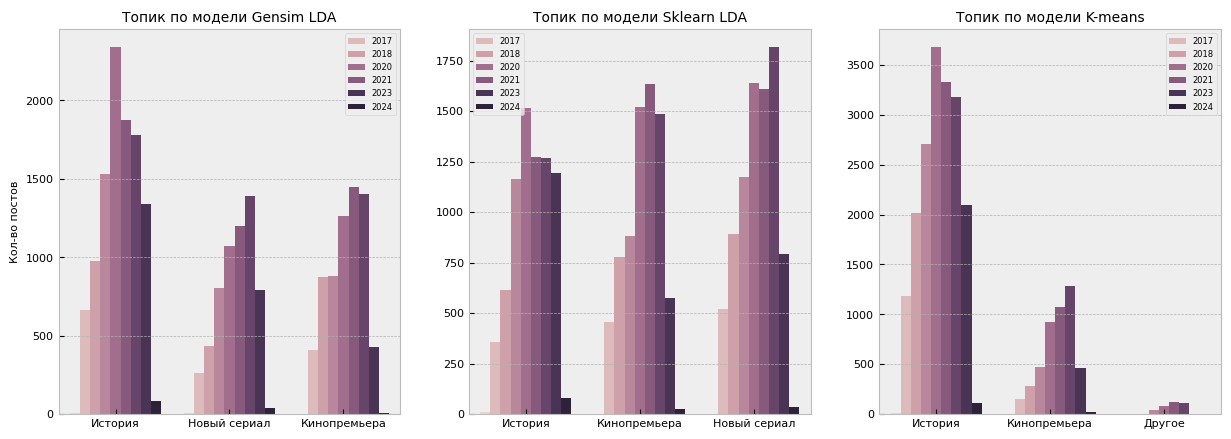

In [ ]:
num_list = [1, 2, 3]
topic_list = ['topic_1', 'topic_2', 'topic_3']
model_name = ['Gensim LDA', 'Sklearn LDA', 'K-means']

plt.figure(figsize=(15,5))
for i, j, k in zip(num_list, topic_list, model_name):
    axes = plt.subplot(1,3,i)
    sns.countplot(df_result, x=j, hue='year')
    plt.title(f'Топик по модели {k}', fontsize=10)
    if i == 1:
        plt.ylabel('Кол-во постов', fontsize=8)
    else:
        plt.ylabel('')
    plt.xlabel('')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.legend(loc='best', fontsize=6)

plt.show()

На первый взгляд какой-то особой зависимости от года и распределения количества постов внутри тематической рубрики нет.

Можно утверждать, что динамика кол-ва постов в отдельных темах совпадет с общей динамикой постов в целом

### 4.2 Выделение главной темы

Если смотреть на общее распределение тем по тройкам тем, то из 20 возможных наборов троек, первые 10 - более 90% всех постов, поэтому можно назначить общую тему данным наборам тем экспертным путем, а остальным тройкам тем назначить одну из тем, например по наименованию первого топика

In [ ]:
print('Первые 10 троек тем по кол-ву постов - примерно {:.2%}'.format(global_topic_distribution.head(10)['id'].sum()/df.shape[0]))
#display(global_topic_distribution.head(10))

Первые 10 троек тем по кол-ву постов - примерно 91.32%


Замену значений произведем функцией подстановки заданной темы на основании значений из столбцов

In [ ]:
def gen_category(row):
    '''
    Функция проводит проверку значений в столбцах датафрейма и выводит значение в новом столбце, которое соответствует условию
    '''
    if row['topic_1'] ==  "История"  and  row['topic_2'] == "История" and row['topic_3'] == "История":
        return "Ретроспектива, сюжеты, интервью"
    elif row['topic_1'] ==  "Кинопремьера"  and  row['topic_2'] == "Кинопремьера" and row['topic_3'] == "История":
        return "Анонс новинок"
    elif row['topic_1'] ==  "История"  and  row['topic_2'] == "Кинопремьера" and row['topic_3'] == "История":
        return "Новости кинопроката"
    elif row['topic_1'] ==  "Новый сериал"  and  row['topic_2'] == "Новый сериал" and row['topic_3'] == "Кинопремьера":
        return "Дайджесты сериалов"
    elif row['topic_1'] ==  "Кинопремьера"  and  row['topic_2'] == "Новый сериал" and row['topic_3'] == "История":
        return "Анонс новинок"
    elif row['topic_1'] ==  "Новый сериал"  and  row['topic_2'] == "Новый сериал" and row['topic_3'] == "История":
        return "Дайджесты сериалов"
    elif row['topic_1'] ==  "История"  and  row['topic_2'] == "Новый сериал" and row['topic_3'] == "История":
        return "Ретроспектива, сюжеты, интервью"
    elif row['topic_1'] ==  "Новый сериал"  and  row['topic_2'] == "История" and row['topic_3'] == "История":
        return "Дайджесты сериалов"
    elif row['topic_1'] ==  "История"  and  row['topic_2'] == "История" and row['topic_3'] == "Кинопремьера":
        return "Ретроспектива, сюжеты, интервью"
    elif row['topic_1'] ==  "Новый сериал"  and  row['topic_2'] == "История" and row['topic_3'] == "Кинопремьера":
        return "Дайджесты сериалов"
    else:
      return "Другое"

In [ ]:
%%time
df_result['topic'] = df_result.apply(gen_category, axis=1)

CPU times: user 989 ms, sys: 7.78 ms, total: 997 ms
Wall time: 1.04 s


В рамках предыдущих этапов моделирования визуально было выявлено несколько важных ммоентов:

1) Некоторые посты содержат информацию о подкастах (Всего 1004 поста). В целом ключевое слово "подкаст" выделялось при  моделировании и среди популярных слов в рамках всех 3-х моделей, но было размазано по другим более "глобальным" темам. Целесообразно выделить такие посты в отдельную тему.

2) Некоторы посты содержат призыв или хэштеги, например "Дождались!", "#дежурныйпокинопоиску". Подобные посты в целом можно выделить в отдельные небольшие тематические рубрики

3) Также часть постов содержат просто некий призыв, например "Делитесь мнением в комментариях", "ждем ваши ответы в комментах"

In [ ]:
print('Кол-во постов, содержащих словo "трейлер" и его словоформы:', df_result[df_result['text'].str.contains('трейлер', case=False)].shape[0])
print('Кол-во постов, содержащих словo "дождались" и его словоформы:', df_result[df_result['text'].str.contains('дождались', case=False)].shape[0])
print('Кол-во постов, содержащих словo "подкаст" и его словоформы:', df_result[df_result['text'].str.contains('подкаст', case=False)].shape[0])
print('Кол-во постов, содержащих словo "#дежурный" и его словоформы:', df_result[df_result['text'].str.contains('#дежурный', case=False)].shape[0])
print('Кол-во постов, содержащих словo "постер" и его словоформы:', df_result[df_result['text'].str.contains('постер', case=False)].shape[0])
print('Кол-во постов, содержащих призыв "Делитесь мнением в комментариях" и его словоформы:', df_result[df_result['text'].str.contains('делитесь мнением в комментариях', case=False)].shape[0])
print('Кол-во постов, содержащих призыв "ждем ваши ответы в комментах" и его словоформы:', df_result[df_result['text'].str.contains('ждем ваши ответы в комментах', case=False)].shape[0])
print('Кол-во постов, содержащих словo "скачать" и его словоформы:', df_result[df_result['text'].str.contains('скачать', case=False)].shape[0])

Кол-во постов, содержащих словo "трейлер" и его словоформы: 2128
Кол-во постов, содержащих словo "дождались" и его словоформы: 47
Кол-во постов, содержащих словo "подкаст" и его словоформы: 1004
Кол-во постов, содержащих словo "#дежурный" и его словоформы: 8
Кол-во постов, содержащих словo "постер" и его словоформы: 896
Кол-во постов, содержащих призыв "Делитесь мнением в комментариях" и его словоформы: 4
Кол-во постов, содержащих призыв "ждем ваши ответы в комментах" и его словоформы: 16
Кол-во постов, содержащих словo "скачать" и его словоформы: 6


4) Примерно 1000 постов имеют длину лемматизированного текста менее 5 слов. Такие посты содержат поздравления с праздниками, информированием подписчиков о статусе, статистике канала, мемы, различные призывы.
Частично такие посты попали в различные рубрики.

Целесообразно их выделить в отдельную рубрику с названием "ниочемиобовсем"

In [ ]:
df_result.query('lenght <=5').groupby('topic')['id'].count().reset_index()

,topic,id
0,Анонс новинок,161
1,Дайджесты сериалов,302
2,Другое,374
3,Новости кинопроката,58
4,"Ретроспектива, сюжеты, интервью",149


In [ ]:
# примеры коротких постов
#display(df_result.query('lenght <=5 and topic == "Другое"')[['id', 'text']].sample(10))
#display(df_result.query('lenght <=5 and topic == "Подборки фильмов, памятные даты, исследования"')[['id', 'text']].sample(10))
#display(df_result.query ('lenght <=5 and topic == "Анонсы кинопремьер, новости будущего кинопроката, слухи о проектах, кадры/видео с мест съемок"')[['id', 'text']].sample(10))

In [ ]:
df_result.loc[df_result['lenght'] <=5, 'topic'] = "Everything"

In [ ]:
df_result.loc[df_result['text'].str.contains('подкаст', case=False), 'topic'] = "Подкаст"
df_result.loc[df_result['text'].str.contains('трейлер', case=False), 'topic'] = "Трейлер"
df_result.loc[df_result['text'].str.contains('дождались', case=False), 'topic'] = "#Дождались"
df_result.loc[df_result['text'].str.contains('#дежурный', case=False), 'topic'] = "#Дежурныйпокинопоиску"
df_result.loc[df_result['text'].str.contains('делитесь мнением в комментариях', case=False), 'topic'] = "Болталка"
df_result.loc[df_result['text'].str.contains('ждем ваши ответы в комментах', case=False), 'topic'] = "Болталка"
df_result.loc[df_result['text'].str.contains('ответы в комментах', case=False), 'topic'] = "Болталка"
df_result.loc[df_result['text'].str.contains('скачать', case=False), 'topic'] = "Другое"
df_result.loc[df_result['text'].str.contains('постер', case=False), 'topic'] = "Постер"

In [ ]:
df_result.groupby('topic')['id'].count().reset_index().sort_values(by='id', ascending=False)

,topic,id
10,"Ретроспектива, сюжеты, интервью",5886
3,Анонс новинок,4923
5,Дайджесты сериалов,3664
7,Новости кинопроката,2903
11,Трейлер,2006
6,Другое,1393
8,Подкаст,987
9,Постер,896
2,Everything,589
1,#Дождались,42


Таким образом, в итоге получили 12 различных тем, на которые удалось классифицировать посты.

In [ ]:
df_result.to_csv('/Мастерская_Кинопоиск/models/df_topic_results.csv')

<a id="comp"></a>
## 5 Сложность текста


### 5.1. Подход к определению сложности

Оценим сложность текста и рассчитаем:
- среднюю длину предложения в тексте,
- индекс синтаксической сложности, рассчитываемое как отношение кол-ва существительных к длине текста:
  - значение близкое к 1 - почти все слова в тексте являются существительными, что может указывать на сложности в структуре предложений.
  - значение близкое к 0 - существительные составляют только небольшую часть текста, что может свидетельствовать о более простой структуре предложений и/или большом разнообразии используемых частей речи.
- метрику отвечающую за "уровень читаемости" (Flesch Reading Ease):
  - 90-100: Очень легко читаемый текст. Понятен для среднего школьника.
  - 80-89: Легко читаемый текст. Понятен для 11-летних.
  - 70-79: Достаточно легко читаемый текст. Понятен для студентов средних классов.
  - 60-69: Средний текст. Понятен для студентов университета.
  - 50-59: Сложный текст. Понятен для выпускников университетов.
  - 30-49: Очень сложный текст. Требует высокого уровня образования.
  - 0-29: Текст для специалистов. Требует особого обучения.

Для этого сформируем 3 функции для расчета соответствующих значений

In [ ]:
# загрузим тегер
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.


True

In [ ]:
def sent_len(text):
    '''
    Функция принимает на вход текст, токенизирует его и рассчитывает среднюю длину предложения  в тексте
    '''
    sentences = nltk.sent_tokenize(text, language='russian')
    lengths = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence, language='russian')
        lengths.append(len(words))
    return sum(lengths) / len(lengths)

In [ ]:
def synt_complexity(text):
    '''
    Функция принимает на вход текст, токенизирует его, размечает тегами (информацией о части предложения), отбирает существительные.
    Значение индекса - отношение числа существительных к общему количеству слов в тексте.
    '''
    tokens = nltk.word_tokenize(text) # токенизация
    tagged = nltk.pos_tag(tokens) # присваивание тега
    nouns = []
    for word, pos in tagged:
        if pos.startswith('N'): # определение существительного
            nouns.append(word)
    return len(nouns) / len(tokens)

In [ ]:
def readability_score(text):
    '''
    Функция принимает на вход текст и рассчитывает его индекс сложности восприятия
    Источник: https://pypi.org/project/textstat/
    '''
    return textstat.flesch_reading_ease(text)

Применим функции к необработанному тексту, т.к. пользователь не взаимодейтсвиует с предобработанным и лемматизированным текстом, и посмотрим на полученное распределение.

In [ ]:
%%time
df_result['sent_len'] = df['text'].apply(sent_len)
df_result['synt_comp'] = df_result['text'].apply(synt_complexity)
df_result['fre'] = df_result['text'].apply(readability_score)

CPU times: user 2min 36s, sys: 951 ms, total: 2min 37s
Wall time: 2min 46s


1) В виде гистограмм

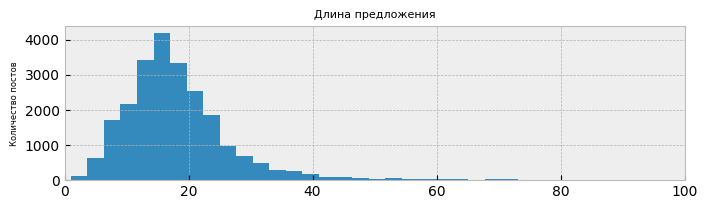

Средняя Длина предложения 18.55, медианная - 16.83


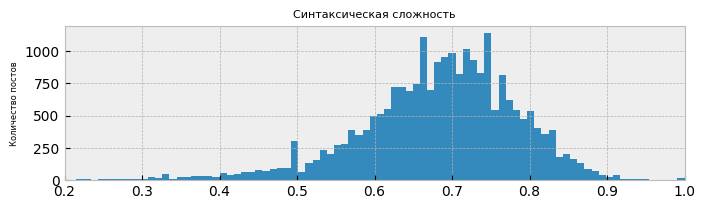

Средняя Синтаксическая сложность 0.68, медианная - 0.69


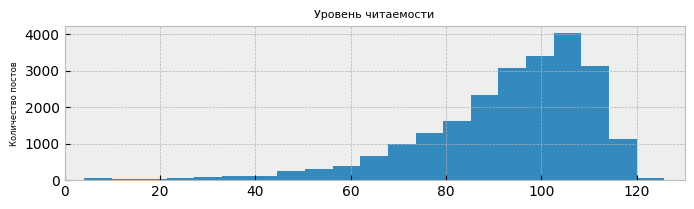

Средний Уровень читаемости 91.92, медианный - 96.86


In [ ]:
# создадим списки для цикла построения графиков
coef = ['sent_len', 'synt_comp', 'fre']
coef_rus = ['Длина предложения', 'Синтаксическая сложность', 'Уровень читаемости']
# гистограммы распределений коэффициентов
for i,j in zip(coef, coef_rus):
    plt.figure(figsize=(8,2))
    plt.title(f'{j}',fontsize=8)
    df_result[i].hist(bins=100)
    if i == "sent_len":
        plt.xlim(0, 100)
    elif i == "synt_comp":
        plt.xlim(0.2, 1)
    elif i == "fre":
        plt.xlim(0, 130)
    plt.ylabel('Количество постов', fontsize=6)
    plt.show()
    if i == "fre":
        print(f'Средний {j} {round(df_result[i].mean(), 2)}, медианный - {round(df_result[i].median(), 2)}')
    else:
        print(f'Средняя {j} {round(df_result[i].mean(), 2)}, медианная - {round(df_result[i].median(), 2)}')

2) Рассмотрим корреляции индексов

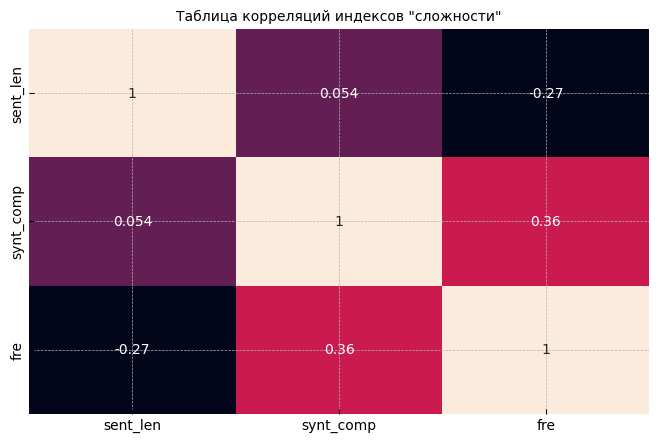

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df_result[['sent_len', 'synt_comp', 'fre']].corr(), annot=True, cbar=False)
plt.title('Таблица корреляций индексов "сложности"', fontsize=10)
plt.show()

In [ ]:
# общие статистики
df_result[['sent_len', 'synt_comp', 'fre']].describe()

,sent_len,synt_comp,fre
count,23326.00,23326.00,23326.00
mean,18.55,0.68,91.92
std,11.09,0.10,22.77
min,1.00,0.08,-372.51
25%,12.80,0.63,84.17
50%,16.83,0.69,96.86
75%,21.67,0.75,105.76
max,268.00,1.00,206.84


В целом особой корреляционной зависимости между посчитанными коэффициентами нет. Сами по себе данные коэффиценты ничего не значат и сложность текста оценивается в том числе на основании субективных параметров и ощущений читателя.

Но имея значения коэффициентов, также можно дополнительно классифицировать посты по сложности восприятия/читабельности и т.д., например:
- по длине (в среднем 18 слов):
  - до 12 слов в предложении - простой
  - от 13 до 20 слов в предложени - обычный
  - более 20 слов в предложении - сложный

Т.е. по большому счету в основном текст обычный по длине


- по синтакситеской сложности (в среднем 0,68):
  - коэф. менее 0,65 - простой
  - коэф. от 0,65 до 0,75 - обычный
  - коэф. более 0,76 - сложный

Т.е. в основном текст постов обычный по синтаксической сложности и простых постов больше, чем сложный.

- по читаемости (в среднем 92):
  - более 70 - простой
  - от 61 до 69 - средний
  - менее 60 - сложный

Т.е. текст постов по большей части простой по индексу читаемости.

Для дополнительной классификации сформируем 3 новых функции, возвращающие класс сложности текста в зависимости от количественных значений расчетных параметров.

Также можно сформировать интегральный показатель сложности

In [ ]:
def sent_len(row):
    if row <= 12:
        return 'легкий'
    if row >12 and row < 20:
        return 'обычный'
    if row >=20:
        return 'сложный'

def synt_comp(row):
    if row <= 0.65:
        return 'легкий'
    if row > 0.65 and row < 0.75:
        return 'обычный'
    if row >= 0.75:
        return 'сложный'

def fre(row):
    if row <= 60:
        return 'сложный'
    if row > 60 and row < 70:
        return 'обычный'
    if row >= 70:
        return 'легкий'

In [ ]:
df_result['comp_len'] = df_result['sent_len'].apply(sent_len)
df_result['comp_synt'] = df_result['synt_comp'].apply(synt_comp)
df_result['comp_fre'] = df_result['fre'].apply(fre)

In [ ]:
df_result.groupby(['comp_len',	'comp_synt',	'comp_fre'])['id'].count().reset_index().sort_values(by='id', ascending=False)

,comp_len,comp_synt,comp_fre,id
12,обычный,обычный,легкий,4454
21,сложный,обычный,легкий,2800
9,обычный,легкий,легкий,2749
15,обычный,сложный,легкий,2380
24,сложный,сложный,легкий,2142
...,...,...,...,...
5,легкий,обычный,сложный,15
4,легкий,обычный,обычный,13
17,обычный,сложный,сложный,8
8,легкий,сложный,сложный,7


С одной стороны мы получили 3 разных метрики, которые могут друг другу противоречить. Например, с точки зрения длины предложения, текст может быть легким, но в соответствии с индексом синтаксической сложности и читабельности - сложным. Таких постов в наборе, например, 3.

Т.е. текст может содержать мало слов, но состоять из терминов и определений, знакомых только специалистам ("Шпур тензора квадрупольного момента равномерно заряженного по объему эллипсоида равен нулю")

С другой стороны существуют готовые решения для определения сложности текста на основании множества метрик. В основном такие решения используются для опеределения сложности текстов нормативно-правовых актов и прочих официальных документов. Примеры:
- https://lawreadability.hse.ru/
- http://ru.readability.io/

Для оценки сложности текстов в данных работах используются различные индексы и метрики, например:
- Flesch–Kincaid readability tests
- Coleman–Liau index
- Automatic Readability Index
- SMOG
- Dale–Chall readability formula
- и др. (Flesch Kincaid Grade Level, Gunning Fog Index, Automated Readability Index (ARI),Linsear Write, SPACHE).

а также:

- доля глаголов в оцениваемом тексте (ГЛ)
- количество слов в субстантивных именных словосочетаниях в каждом предложении оцениваемого текста
- количество слов в абзацах
- расстояние между зависимыми словами в оцениваемом тексте
- количество причастных оборотов, расположенных после определяемого слова, приходящихся на 1 предложение оцениваемого текста
- количество слов в предложении в каждом предложении оцениваемого текста
- количество грамматических основ (предикативных основ, предикативных ядер) предложения (подлежащее – сказуемое или одно из них) в каждом предложении оцениваемого текста


### 5.2. Определение итоговой сложности

Реализуем следующем методологический подход основанный на бальной системе и весах:
Сложный текст 3 балла, простой - 2 балла, легкий - 1 балл
- сложность по длине имеет вес 0,3.
- сложность по читаемости имеет вес 0,1
- сложность по синтаксической метрике имеет вес 0,6

Т.о. итоговая сложность средневзвешенное баллов в зависимости от весов, значит данный показатель будет лежать в пределах от 0,9 до 2,7

In [ ]:
def comp_score(row):
    '''
    Функция возвращает значение итогово индекса сложности
    '''
    score = {'легкий': 1, 'обычный': 2, 'сложный': 3}
    return score[row['comp_len']] * 0.2 + score[row['comp_fre']] * 0.3 + score[row['comp_synt']] * 0.5

In [ ]:
df_result['comp_score'] = df_result.apply(lambda row: comp_score(row), axis=1)

Рассмотрим на распеределние итогового индекса от количества постов. Распределение будет по большей части дискретным, т.к. баллы выставляются по категоряим и в явном виде наблюдается четкое распределение по сложности текста:
- итоговый балл менее 1,5 - легкий текст
- итоговый балл от 1,5 до 2 - обычный текст
- итоговый балл более 2 - сложный текст

In [ ]:
df_result['comp_score'].describe()

count   23326.00
mean        1.74
std         0.42
min         1.00
25%         1.50
50%         1.70
75%         2.00
max         3.00
Name: comp_score, dtype: float64

<Axes: >

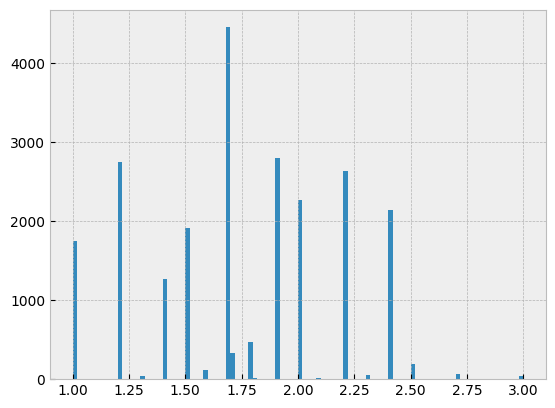

In [ ]:
df_result['comp_score'].hist(bins=100)

In [ ]:
def complexity(row):
    if row < 1.5:
        return "легкий"
    if row >= 1.5 and row <= 2.5 :
        return "обычный"
    if row > 2.5:
        return "сложный"

In [ ]:
df_result['complexity'] = df_result['comp_score'].apply(complexity)

In [ ]:
df_result[['id', 'text', 'comp_score', 'complexity']]

,id,text,comp_score,complexity
0,37125,"Какими подростками были актеры из «Трудных подростков»? А что они помнят о своей первой любви?\n\nПоговорили с кастом сериала — Милой Ершовой, Святославом Рогожаном, Анастасией Красовской (@nastitasti) и Дашей Верещагиной. \n\n[Вспомнили](https://www.kinopoisk.ru/media/article/4008982/) самый яр...",1.70,обычный
1,37121,"Фильм дня — [**«Дневник Бриджит Джонс»**](https://www.kinopoisk.ru/film/621/) (18+) 🎬\n\nБриджит Джонс — 32 года, она не замужем, переживает из-за лишнего веса и хочет избавиться от вредных привычек. Чтобы привести свои жизнь в порядок, Бриджит решает вести дневник. Теперь героине предстоит выбр...",1.70,обычный
2,37120,"Кристоферу Нолану [вручат](https://www.hollywoodreporter.com/movies/movie-news/christopher-nolan-honorary-cesar-1235793056/) почетную премию «Сезар» за выдающиеся достижения в кинематографе — главный киноприз Франции. \n\nКак говорится в заявлении Французской киноакадемии, режиссер «переопределя...",1.90,обычный
3,37119,"Отгадайте фильм: в жизни грустной девочки появляется незадачливый молодой отец — и все это режиссерский дебют британской кинематографистки. \n\nНет, это не «Солнце мое», а «Задира» — пронзительное драмеди с Харрисом Диккинсоном из «Треугольника печали»! Сняла фильм Шарлотта Риган, и он уже успел...",2.20,обычный
4,37118,Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Сергей Сироткин пытается отличить настоящие новости от выдуманных.\n\nПолный [выпуск нашего шоу](https://youtu.be/KOhDZReSQrs?si=wL9bwB_vJthBC6qp) — уже на YouTube-канале «Кинопоиск Экстра»!\n\n🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk),1.20,легкий
...,...,...,...,...
23321,13,"Кстати, уже через три часа, в 16-00 по Москве начнется прямой эфир с руководителями КиноПоиска - я буду рассказывать о редакции, а Саша Кочубей будет говорить о развитии сервиса. Если у вас есть вопросы о нашем сайте, вы сможете их задать в комментариях - трансляцию мы будем вести на сайте и в ...",2.40,обычный
23322,11,"И, кстати, у нас есть первая тысяча подписчиков! Спасибо, что вы с нами",2.00,обычный
23323,10,"Первые счастливчики уже посмотрели новый эпизод «Шерлока» (The Six Thatchers), который доберется до всех 1 января. Если верить отзывам, сериал возвращается в отличной форме, сразу выдает несколько неожиданных поворотов и сильно прибавляет в экшене, который достойно выглядел бы и в фильмах о Бонд...",1.70,обычный
23324,9,"Каждый год кто-то ходит в баню, а мы выбираем лучшие фильмы. Без лишних комментариев представляем вам 15 лучших фильмов 2016 года по мнению редакции КиноПоиска. https://www.kinopoisk.ru/news/2867126/",1.00,легкий


## 6 Анализ комментариев к поста в телеграм канале Кинопоиска

Ниже проведен анализ тональности комментариев, оставленных пользователями в телеграм канале кинопоиск.

**Данные**: текст комментариев пользователей и иные метаданные комментариев. Данные предоставлены заказчиком.

### 6.1. Загрузка данных и предобработка

- датасет с комментариями
- датасет с постами (необходимо id и дата)

1) добавим столбцы в комментарии: год год комментария, месяц поста, день года коментария, час дня

2) добавим столбцы в посты: день года, час дня поста

ВАЖНО! данные о комментариях только с конца 2022 года, т.к. возможно в канале возможность комментирования была включена не с момента создания канала.

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # путь к api
public_key = 'https://disk.yandex.ru/d/XwP_zGtsL2dAUw'  # ссылка на директорию

# загрузочная ссылка
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url) #запрос к файлу
download_url = response.json()['href']

# загрузка и сохранение файла  в папке на Google.Drive
download_response = requests.get(download_url)
with open('/content/drive/MyDrive/Хакатон Кинопоиск/comments_kinopisk_2023_01_18.csv', 'wb') as f:   # путь к файлу
    f.write(download_response.content)

In [ ]:
# датафрейм с комментариями
comm = pd.read_csv('/content/drive/MyDrive/Хакатон Кинопоиск/comments_kinopisk_2023_01_18.csv')
# датафрейм с постами
posts_file = pd.read_csv('/content/drive/MyDrive/Хакатон Кинопоиск/kinopoisk_channel_posts_2023-01-21.csv')

Предобработка датафрейма с постами

In [ ]:
posts = posts_file[['id', 'date']].copy(deep=True)

In [ ]:
posts['post_date'] = pd.to_datetime(posts['date'])
posts['post_day_of_year'] = posts['post_date'].dt.dayofyear
posts['post_hour'] = posts['post_date'].dt.hour

In [ ]:
posts['year_post'] = posts['post_date'].dt.year

Предобработка датафрейма с комментариями

In [ ]:
comm.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
#comm

In [ ]:
comm['date_comm'] = pd.to_datetime(comm['date_comment'])
comm['year_comm'] = comm['date_comm'].dt.year
comm['month'] = comm['date_comm'].dt.month
comm['day_of_year'] = comm['date_comm'].dt.dayofyear
comm['hour'] = comm['date_comm'].dt.hour

In [ ]:
#comm

### 6.2 Объединим датафреймы

In [ ]:
comm = comm.merge(posts, left_on='post_id', right_on='id', how='left')

In [ ]:
comm.drop(['date_comment', 'date'], axis=1, inplace=True)

In [ ]:
comm['delta_day'] = comm['day_of_year'] - comm['post_day_of_year']
comm['delta_hour'] = comm['hour'] - comm['post_hour']

In [ ]:
comm.head()

,post_id,text_comment,date_comm,year_comm,month,day_of_year,hour,id,post_date,post_day_of_year,post_hour,year_post,delta_day,delta_hour
0,37068,"От бесстыжих к медведю - так это скорее не путь, а спуск",2024-01-18 09:34:31+00:00,2024,1,18,9,37068,2024-01-18 09:32:47+00:00,18,9,2024,0,0
1,37068,учился орать FUCK!,2024-01-18 09:35:00+00:00,2024,1,18,9,37068,2024-01-18 09:32:47+00:00,18,9,2024,0,0
2,37068,Верните бестыжих,2024-01-18 09:35:11+00:00,2024,1,18,9,37068,2024-01-18 09:32:47+00:00,18,9,2024,0,0
3,37068,От липа из бесстыжих до рекламы кельвин кляйн,2024-01-18 09:36:34+00:00,2024,1,18,9,37068,2024-01-18 09:32:47+00:00,18,9,2024,0,0
4,37068,"этот навык был освоен еще в ""бесстыжих""🧡",2024-01-18 09:37:41+00:00,2024,1,18,9,37068,2024-01-18 09:32:47+00:00,18,9,2024,0,0


In [ ]:
#comm.describe()

Сформируем некоторые агрегирующие датасеты.

1) посчитаем среднее кол-во комментариев на пост


In [ ]:
comm_year = comm.groupby('year_comm')['id'].count().reset_index()
posts_year = posts.groupby('year_post')['id'].count().reset_index()
posts_comm = pd.merge(comm_year, posts_year, left_on='year_comm', right_on='year_post', how='left')
posts_comm['ratio'] = posts_comm['id_x'] / posts_comm['id_y']
posts_comm = posts_comm.rename(columns={'id_x' : 'comm_cnt', 'id_y' : 'posts_cnt'})
posts_comm

,year_comm,comm_cnt,year_post,posts_cnt,ratio
0,2022,26205,2022,4572,5.73
1,2023,107768,2023,2561,42.08
2,2024,5549,2024,134,41.41


In [ ]:
days_hours = comm.groupby(['year_comm', 'delta_day'])['id'].count().reset_index()
days_hours

,year_comm,delta_day,id
0,2022,0,21598
1,2022,1,3314
2,2022,2,439
3,2022,3,222
4,2022,4,180
...,...,...,...
334,2024,7,11
335,2024,8,4
336,2024,9,2
337,2024,12,4


2) Рассмотрим распределение коментариев в зависимости от "задержки" в комментировании с момента публикации поста

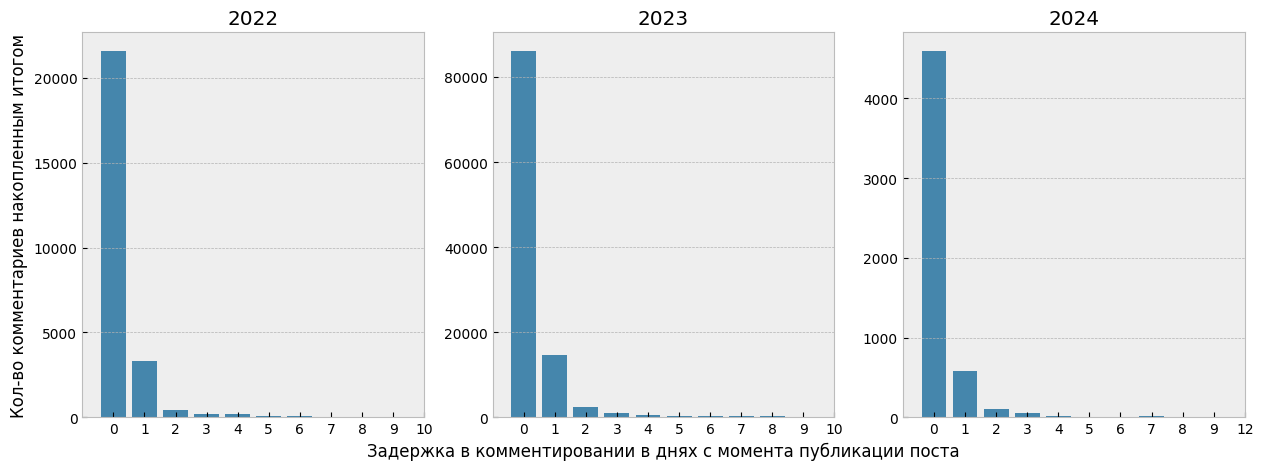

In [ ]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1,3,1)
plt.title('2022')
sns.countplot(data=comm.query('year_comm == 2022 and delta_day >= 0'), x='delta_day')
plt.xlabel('')
plt.ylabel('Кол-во комментариев накопленным итогом')
plt.xlim(-1, 10)

ax1 = plt.subplot(1,3,2)
plt.title('2023')
sns.countplot(data=comm.query('year_comm == 2023 and delta_day >= 0'), x='delta_day')
plt.xlabel('Задержка в комментировании в днях с момента публикации поста')
plt.ylabel('')
plt.xlim(-1, 10)

ax1 = plt.subplot(1,3,3)
plt.title('2024')
sns.countplot(data=comm.query('year_comm == 2024 and delta_day >= 0'), x='delta_day')
plt.xlabel('')
plt.ylabel('')
plt.xlim(-1, 10)

plt.show()

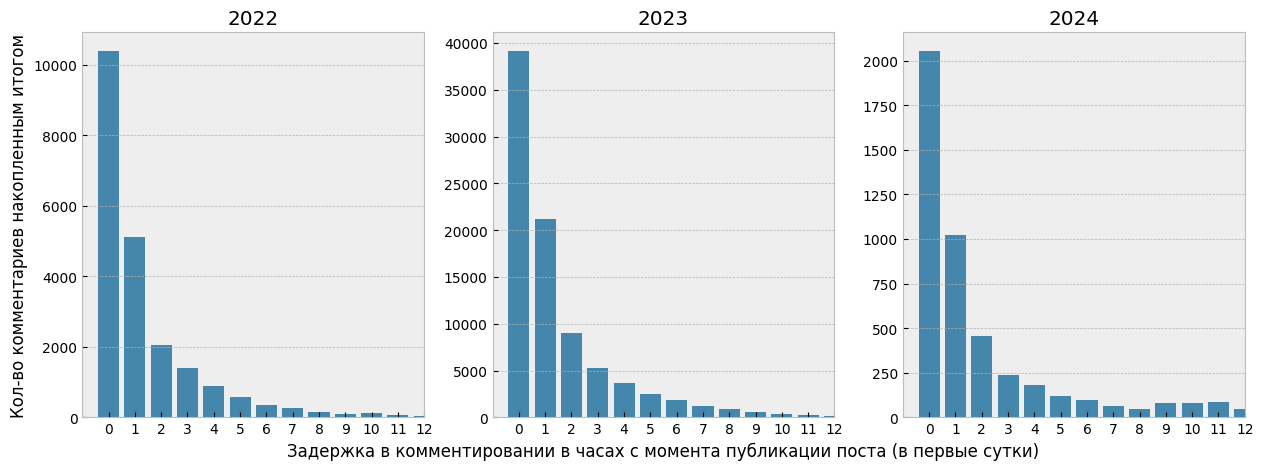

In [ ]:

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1,3,1)
plt.title('2022')
sns.countplot(data=comm.query('year_comm == 2022 and delta_day == 0 and delta_hour >= 0'), x='delta_hour')
plt.xlabel('')
plt.ylabel('Кол-во комментариев накопленным итогом')
plt.xlim(-1, 12)

ax1 = plt.subplot(1,3,2)
plt.title('2023')
sns.countplot(data=comm.query('year_comm == 2023 and delta_day == 0 and delta_hour >= 0'), x='delta_hour')
plt.xlabel('Задержка в комментировании в часах с момента публикации поста (в первые сутки)')
plt.ylabel('')
plt.xlim(-1, 12)

ax1 = plt.subplot(1,3,3)
plt.title('2024')
sns.countplot(data=comm.query('year_comm == 2024 and delta_day == 0 and delta_hour >= 0'), x='delta_hour')
plt.xlabel('')
plt.ylabel('')
plt.xlim(-1, 12)

plt.show()


### 6.3 Сентимент анализ комментариев

#### 6.3.1 Подготовка текста

In [ ]:
%%time
comm['text_processed'] = comm['text_comment'] # новый столбец для обработки
comm['text_processed'] = comm['text_processed'].astype(str).str.strip() # удаление лишних пробелов, если есть
comm['text_processed'] = comm['text_processed'].str.lower() # приведение к строчным
comm['text_processed'] = comm['text_processed'].str.replace('[{}]'.format(string.punctuation), '')
# удалим все эмодзи с помощью функции replace_emoji библиотеки emoji
for i in comm['text_processed'].index:
    comm.loc[i, 'text_processed'] = emoji.replace_emoji(comm.loc[i, 'text_processed'], replace='')

CPU times: user 31 s, sys: 114 ms, total: 31.2 s
Wall time: 31.5 s


In [ ]:
# удалим кавычки типа « » на ""
comm['text_processed'] = comm['text_processed'].replace(r'\«' , '')
comm['text_processed'] = comm['text_processed'].replace(r'\»' , '')

#### 6.3.2 Моделирование

Для определения тональности можно использовать различные библиотеки. В мире лингвистического и семантического анализа распространены методы, включенные в библиотеку TextBlob, но как будет показано ниже, библиотека достаточно медленная и ресурсоемкая.

Для быстрого анализа тональности текста на русском языке используется в т.ч. методы и модели бибилиотеки dostoevsky, основанной на нейросетевых алгоритмах (минус библиотеки на наш взгляд - отсутствие толковой подержки и обновления бибилиотеки, а также очень поверхностная документация)

##### 6.3.2.1 TextBlob
Сформируем функцию для сентимент анализа на основе наивного Байесовского анализатора и библиотеки TextBlob.

Для работы библиотеки нет нужды подготавливать дополнительно текстовый массив и есть возможность анализировать непосредственно данные из датафрейма напрямую

In [ ]:
#print(TextBlob('учился орать FUCK!').sentiment)

In [ ]:
'''
text = comm['text_processed'].to_numpy()
sentiments = []
#sentiments_polarity = []
#sentiments_subjectivity = []
for comment in tqdm_notebook(text):
    blob = TextBlob(comment, analyzer=NaiveBayesAnalyzer())
    sentiment = blob.sentiment
    #polarity = blob.polarity
    #subjectivity = blob.subjectivity
    #sentiments.append(sentiment)
 #   sentiments_polarity.append(polarity)
 #   sentiments_subjectivity.append(subjectivity)
'''

"\ntext = comm['text_processed'].to_numpy()\nsentiments = []\n#sentiments_polarity = []\n#sentiments_subjectivity = []\nfor comment in tqdm_notebook(text):\n    blob = TextBlob(comment, analyzer=NaiveBayesAnalyzer())\n    sentiment = blob.sentiment\n    #polarity = blob.polarity\n    #subjectivity = blob.subjectivity\n    #sentiments.append(sentiment)\n #   sentiments_polarity.append(polarity)\n #   sentiments_subjectivity.append(subjectivity)\n"

In [ ]:
# функция для определения тональности текста с помощью TextBlob
def sentiment_texblob(text):
    sentiment = []
    sentiments_polarity = []
    sentiments_subjectivity = []
    for comment in tqdm_notebook(text):
        blob = TextBlob(comment, analyzer=NaiveBayesAnalyzer())
        sentiment = blob.sentiment
        polarity = blob.polarity
        sobjectivity = blob.subjectivity
        if sentiment.classification == 'pos':
            sentiments.append('Positive')
        elif sentiment.classification == 'neg':
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')
    return sentiments

Вызов данной функции ресурсозатратен, 3 комментарияя из 139 тыс. обрабатываются примерно 20 сек. Общее время обработки составило бы более 200 часов (3/139522 [00:22<205:18:11,  5.30s/it])

##### 6.3.2.2 Dostoevsky

Поэтому применим другой метод и библиотеку - [dostoevsky](https://pypi.org/project/dostoevsky/), которая в целом больше подходит для анализа тональности текста "комментариев" на русском языке, и обучена на датасете [RuCentiment](https://github.com/text-machine-lab/rusentiment). Поэтому обучения модели проводить нет никакой необходимости.

В отдельных источниках есть упоминание, что набор данных, на котором был обучен алгоритм из бибилиотеки, включал в том числе обучение на данных комментариев пользователей портала Кинопоиск.

Однако, как уже указывалось выше, поддрежка библиотеки по нашим данным прекращена, частично функции и методы библиотеки недоступны. Обучающие данные для модели сформированы в 2018 году и больше не обновлялись.

Модель анализа тональности библиотеки разделяет текст на 5 категорий:
- positive - текст с позитивной тональностью
- negative - текст с негативной тональностью
- neutral	- нейтральный текст
- skip - тональность не распознана
- speech - призыв к действию

In [ ]:
from dostoevsky.tokenization import RegexTokenizer

In [ ]:
# подготовим текст
comments = comm['text_processed'].to_list()

In [ ]:
tokenizer = dostoevsky.tokenization.RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [ ]:
'''
messages = [
    'Сегодня хорошая погода',
    'Я счастлив проводить с тобою время',
    'Мне нравится эта музыкальная композиция',
    'В больнице была ужасная очередь',
    'Сосед с верхнего этажа мешает спать',
    'Маленькая девочка потерялась в торговом центре',
]

results = model.predict(messages, k=2)
for message, sentiment in zip(messages, results):
    print(message, '-&gt;', sentiment)
'''

"\nmessages = [\n    'Сегодня хорошая погода',\n    'Я счастлив проводить с тобою время',\n    'Мне нравится эта музыкальная композиция',\n    'В больнице была ужасная очередь',\n    'Сосед с верхнего этажа мешает спать',\n    'Маленькая девочка потерялась в торговом центре',\n]\n\nresults = model.predict(messages, k=2)\nfor message, sentiment in zip(messages, results):\n    print(message, '-&gt;', sentiment)\n"

In [ ]:
%%time
results = model.predict(comments, k=2)

CPU times: user 15.8 s, sys: 106 ms, total: 15.9 s
Wall time: 16.2 s


In [ ]:
# запишем результаты в датафрейм
sentiment_list =[]
for i in results:
   sent_keys = i.keys()
   sentiment_list.append(max(i, key=i.get))

comm['sentiment'] = pd.DataFrame(sentiment_list)

In [ ]:
comm.groupby('sentiment')['id'].count().reset_index()

,sentiment,id
0,negative,10363
1,neutral,106396
2,positive,16231
3,skip,4404
4,speech,2128


Как видно, основная часть массива комментариев - нейтральные высказывания.

Подобное распеределение в целом характерно для большинства комментариев в любой социальной сети, где пользователями является не слишком восторженная или агрессивно-токсичная публика.

Теперь можем сформировать "справочник" пост - тональность, где будет отражена инофрмация о количестве комментариев в разрезе тональности ко всем постам

In [ ]:
sentiment_df = comm.pivot_table(index='post_id', columns='sentiment', values='id', aggfunc='count').reset_index()
sentiment_df = sentiment_df.fillna(0)
sentiment_df['positive_ratio'] = sentiment_df['positive'] / sentiment_df[['negative',	'neutral',	'positive',	'skip',	'speech']].sum(axis=1)
sentiment_df['negative_ratio'] = sentiment_df['negative'] / sentiment_df[['negative',	'neutral',	'positive',	'skip',	'speech']].sum(axis=1)
sentiment_df['speech_ratio'] = sentiment_df['speech'] / sentiment_df[['negative',	'neutral',	'positive',	'skip',	'speech']].sum(axis=1)
sentiment_df.sort_values(by='negative', ascending=False)

sentiment,post_id,negative,neutral,positive,skip,speech,positive_ratio,negative_ratio,speech_ratio
2068,32573,56.00,448.00,50.00,11.00,3.00,0.09,0.10,0.01
1073,30684,48.00,325.00,28.00,10.00,5.00,0.07,0.12,0.01
3409,35784,47.00,185.00,31.00,7.00,3.00,0.11,0.17,0.01
176,28997,45.00,238.00,31.00,8.00,0.00,0.10,0.14,0.00
1683,31802,43.00,244.00,41.00,45.00,1.00,0.11,0.11,0.00
...,...,...,...,...,...,...,...,...,...
1111,30759,0.00,21.00,1.00,0.00,0.00,0.05,0.00,0.00
1112,30760,0.00,5.00,0.00,0.00,1.00,0.00,0.00,0.17
1113,30769,0.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00
2909,34557,0.00,23.00,1.00,0.00,0.00,0.04,0.00,0.00


Можно составить топ, боттом постов с наибольшим кол-вом позитивных и негативных комментариев.

Например, в топ-50 постов с самым большим кол-вом позитивных комментариев в часто попадали посты с призывом что-то отгадать

In [ ]:
positive_posts = sentiment_df.sort_values(by='positive', ascending=False).head(50)['post_id'].to_list()
#positive_posts
posts_file.query('id in @positive_posts')[['id', 'text']]

,id,text
39,37035,"Фильм дня — [**«Костяной томагавк»,**](https://www.kinopoisk.ru/film/715046/) лютый вестерн с Патриком Уилсоном и Куртом Расселом в главных ролях.\n\nПо сюжету на небольшой городок Брайт-Хоуп ночью кто-то нападает и похищает трех человек. Вскоре выясняется, что набег устроили индейцы настолько с..."
46,37014,Ждем ваши ответы в комментах 🐻\n\n🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)
80,36939,"Устроили киномарафон в выходные или решили посмотреть тот самый фильм, о котором все говорят? Делитесь списком просмотренного в комментариях!\n\n🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)"
125,36862,"Фильм дня не фильм, а сказка [**«По щучьему велению»**](https://www.kinopoisk.ru/film/4959134/?utm_source=telegram&utm_medium=social) с Никитой Кологривым 🎉\n\nЕмеля вытаскивает из реки волшебную Щуку, готовую исполнить три любых желания. Два Емеля тратит на всякую ерунду и решает приберечь трет..."
230,36609,Ждем ответы в комментах 🎄\n\n🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)
...,...,...
2661,31189,По сложившейся традиции [делимся](https://www.kinopoisk.ru/media/article/4007252/?utm_source=telegram&utm_medium=social) лучшими хоррорами 2022 года по версии Станислава Зельвенского.\n\nВ топ-13 соседствуют самые обсуждаемые фильмы и малоизвестные опыты в жанре из разных стран. Бонусом лучший х...
2847,30833,А что по поводу хорроров?\n\nЖурнал RollingStone [подвел итоги](https://www.rollingstone.com/tv-movies/tv-movie-lists/best-horror-movies-of-2022-nope-barbarian-x-prey-jordan-peele-1339213/) года и выбрал топ-10 фильмов ужасов 2022 года:\n\n1. «X»\n2. «Добыча»\n3. «Варвар»\n4. «Не говори никому»\...
2921,30684,"Сегодня президент Владимир Путин подписал закон о запрете «пропаганды ЛГБТ». \n\nКинопоиск [опросил](https://www.kinopoisk.ru/media/article/4007132/?utm_source=telegram&utm_medium=social) издателей, книжные сервисы и экспертов о том, как закон повлияет на их деятельность."
3578,29455,"А следом и постер фильма с Кангом Завоевателем (и главными героями, если присмотреться)!"


Как видно, достаточо много постов с позитивными комментариями - это посты-призывы комметировать, где пользователи комментируют какое-то фото, не содержащее более никакой информации о кино

In [ ]:
sentiment_df.describe()

sentiment,post_id,negative,neutral,positive,skip,speech,positive_ratio,negative_ratio,speech_ratio
count,3931.00,3931.00,3931.00,3931.00,3931.00,3931.00,3931.00,3931.00,3931.00
mean,32586.08,2.64,27.07,4.13,1.12,0.54,0.13,0.07,0.02
std,2419.96,4.21,48.95,5.87,2.63,1.26,0.12,0.08,0.05
min,28701.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,30526.50,0.00,8.00,1.00,0.00,0.00,0.05,0.00,0.00
50%,32380.00,1.00,15.00,3.00,0.00,0.00,0.11,0.06,0.00
75%,34638.50,3.00,30.00,5.00,1.00,1.00,0.18,0.11,0.02
max,37068.00,56.00,946.00,81.00,45.00,33.00,1.00,1.00,1.00


В среднем распределение тональности комментариев по постам следующее:
- каждый пост в среднем содержит примерно 4 позитивных, почти 3 негативных и 27 нейтральных комментария, однако медианные значения для постов равны 5, 3 и 30 соответственно.
- с вероятностью 13% случайный комментарий под постом будет позитивным, а с вероятностью 7% - негативным

In [ ]:
#plt.figure(figsize=(15,5))
#sns.lineplot(comm.query('sentiment !="neutral"').groupby(['date_comm', 'sentiment'])['id'].count().reset_index(), x='date_comm', y='id', hue='sentiment')
#plt.show()

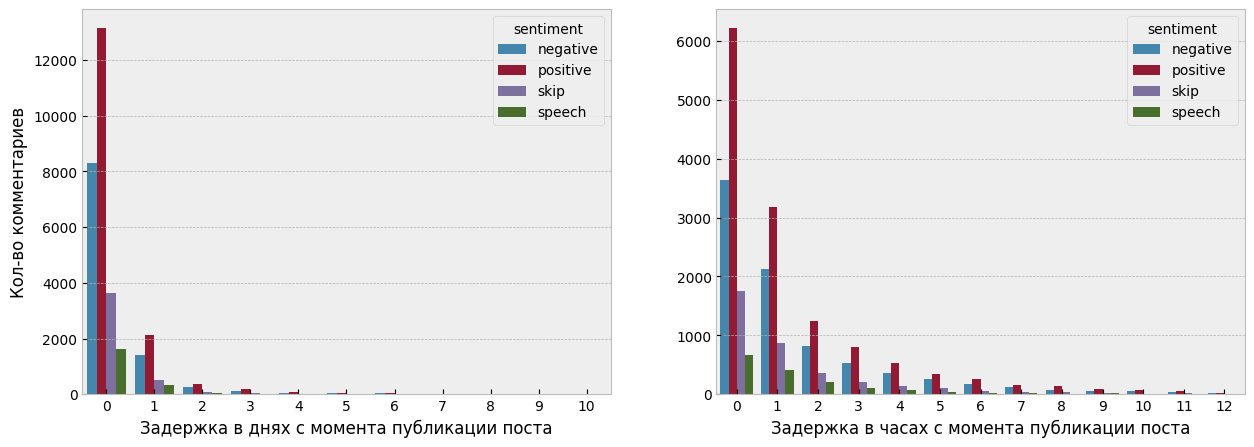

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
(sns.barplot(data = comm.query('delta_day >=0 and \
                                delta_day <= 10 and \
                                sentiment !="neutral"')
             .groupby(['sentiment', 'delta_day'])['id']
             .count().reset_index(), x='delta_day', y='id', hue='sentiment'))
plt.xlabel('Задержка в днях с момента публикации поста')
plt.ylabel('Кол-во комментариев')

ax1 = plt.subplot(1,2,2)
(sns.barplot(data = comm.query('delta_hour >=0 and \
                                delta_hour <= 12 and \
                                sentiment !="neutral" and delta_day == 0')
             .groupby(['sentiment', 'delta_hour'])['id']
             .count().reset_index(), x='delta_hour', y='id', hue='sentiment'))
plt.xlabel('Задержка в часах с момента публикации поста')
plt.ylabel('')
plt.show()

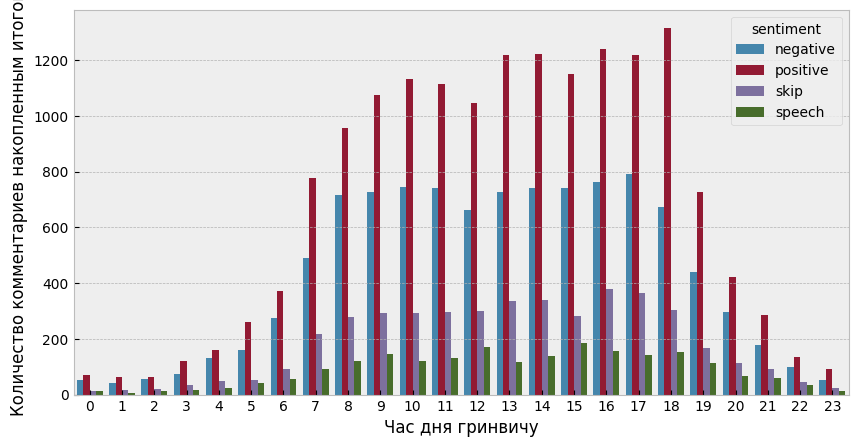

In [ ]:
plt.figure(figsize=(10,5))
sns. barplot(data=comm.query('sentiment !="neutral"').groupby(['hour', 'sentiment'])['id'].count().reset_index(), x='hour', y='id', hue='sentiment')
plt.xlabel('Час дня по гринвичу')
plt.ylabel('Количество комментариев накопленным итогом')
plt.show()

На графике выше представлено распределение комментариев по часам по времени UTC+0, т.е. по гринвичу. Например, на графике максимальное кол-во незитивных комментариев оставлено в 18:00, что соответствует 21:00 по московскому времени.

Попробуем вычислить некий интегральный показатель тональности поста на основании количественных данных о комментариях той или иной тональности

## 7 Итоговые данные

Объединим в одном датафрейме все полученные результаты:

- тематического моделирования
- оценки сложности текста
- анализа тональности

Для этого достаточно присоединить датафреймы по id поста. Т.к. комментарии содержат только часть постов, заменим сразу пропуски данных нулями

In [ ]:
df_final = df_result.merge(sentiment_df, left_on='id', right_on='post_id', how='left')

In [ ]:
df_final = df_final.fillna(0)

Для дальнейшего анализа часть данных из полученного датафрейма нам совершенно не нужна, можем удалить.

Сохраним итоговый датасет в файл

In [ ]:
df_final.to_csv('/Мастерская_Кинопоиск/models/modeling_results.csv', index=False)

In [ ]:
df_final.drop(['text_processed', 'text_lemmatized', 'post_id',
               'topic_gensim', 'topic_sklearn', 'cluster',
               'topic_1', 'topic_2', 'topic_3',
               'sent_len', 'synt_comp', 'fre',
               'comp_len', 'comp_synt', 'comp_fre'], axis=1, inplace=True)

In [ ]:
df_final.to_csv('/Мастерская_Кинопоиск/models/modeling_results_easy.csv', index=False)

Проверим, есть ли какая-либо корреляционная зависимость между полученными количественными характеристиками постов.

Например, между длиной текста, сложностью, коэффициентом связности и кол-вом позитивных и негативных комментариев.

Спойлер: зависимостей нет

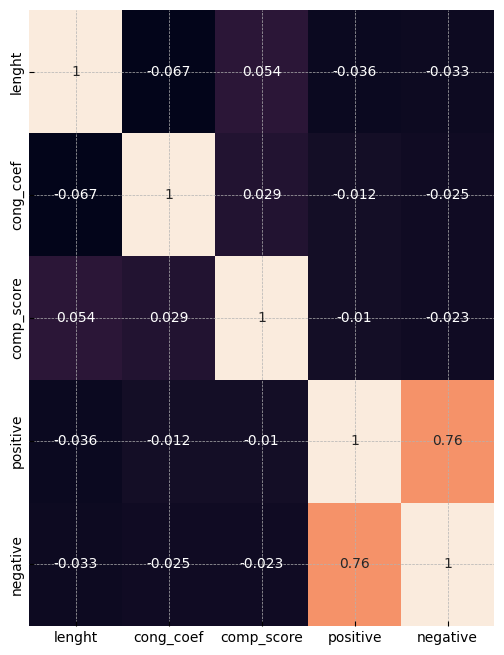

In [ ]:
plt.figure(figsize=(6,8))
sns.heatmap(df_final[['lenght', 'cong_coef', 'comp_score','positive', 'negative']].corr(), annot=True, cbar=False)
plt.show()

In [ ]:
# время окончания
end_time = time.time()
print(f'Время выполнения расчетов: {(end_time - start_time)/60} минут')

Время выполнения расчетов: 27.11519613265991 минут
